<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        print("who is q in AdversarialTraining: ", q)
        # Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        #print(S.shape)
        #print("S ", S)
        partial = S @ param  # should be (m * n,)
        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          param_norm = cp.pnorm(partial, p=q)
        else:  # should be a stack of matrix
          print("multiple matrices in input, S conc")
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False


    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-7, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S, p=np.inf)
    estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
    alphas_adv, coefs_advtrain_linf  = get_path(X, y, estimator, 1e1)
    plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
    plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return alphas_adv, coefs_advtrain_linf


def add_rectangles(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)


print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [105]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       if nbr_mi == 1:
        res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [106]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [107]:
# experiment 2d with dataset generated externally

def imputations(info, X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] == 'mi':
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks']
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['masks_train']

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train'].copy()
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    X_train, y_train, mask_train = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
    n_train, n_test = X_train.shape[0], X_test.shape[0]
    M = np.sum(mask_train, axis=1)  # M[i] > 0 iff i has missing component
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))
    #print("-------> nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))
    #print("M size ", M.size)
    #print("M ", M)
    dict_cov = {'X_imputed': X_train, 'X_nan': X_nan_train, 'masks': mask_train}
    S = cov_strategy(dict_imp, dict_cov)
    print("---....---....----....--> diag matrix: ", np.diag(S))

    alphas_used, coeff_results = train_and_plot(X_train, y_train, S, [ax[1], ax[2]])

    idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
    best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("best idx ", idx_best, " best 1/best_alpha ", 1/best_alpha, ", min score ", min_score)
    print("best coeff ", best_coeff)
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    plt.tight_layout()
    #print(X_br_train[M == 0, 0])
    ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
    ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
    ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
    #
    add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [108]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), num='advtrain_linf_')
    res = {}
    for info_imp_cov_dict in methods_strategy:
      #print("info imp cov dict ", info_imp_cov_dict)
      res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      dict_obser = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])

      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * 3):((idx+1)*3), i])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(15, 5), num='advtrain_linf_res')
  positions = range(l)
  print("res\n ", res)
  ch = ['o', 'x', '+', '*']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    ax_res[i].legend()
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  ax_res[1].set_title("n_test: " + str(n_test))
  ax_res[2].set_ylabel("-log10(alpha)")


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio



change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
n_tot :  20400
n_train :  400
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9803921568627451
err :  {'type': 'Gaussian_on_y', 'scaling': 4}
p_miss :  [0.8, 0.09999999999999998, 0.09999999999999998]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'l_d', 'cov_strategy': 'sd'}, {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}]
imp_method :  BR_si
cov_strategy :  sd
imp_method :  l_d
cov_strategy :  sd
imp_method :  mi
cov_strategy :  sd
mi_nbr :  1
----> Starting experiments
---------------------------------------------------------------------------------------------------------------------------> iteration  0
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20400, 2)
----------------------------------------------> new method tested:  {'imp_me

100%|██████████| 200/200 [00:03<00:00, 65.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  134  best 1/best_alpha  19.33891750455232 , min score  15.910056558944142
best coeff  [-0.46592584  2.08055392]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  316 nbr_seen (train):  316  nbr_miss :  0
---....---....----....--> diag matrix:  [1.06154924 0.10427616]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 67.23it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  133  best 1/best_alpha  20.97046401323231 , min score  15.91180490247212
best coeff  [-0.50351905  1.74289741]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  400 nbr_seen (train):  316  nbr_miss :  84
---....---....----....--> diag matrix:  [1.05431508 0.10456691]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 66.82it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  128  best 1/best_alpha  31.440354715915 , min score  15.910641947279315
best coeff  [-0.4545484   2.22073483]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20800, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  800 nbr_seen (train):  655  nbr_miss :  145
---....---....----....--> diag matrix:  [1.00173565 0.09260641]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 26.90it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  15.876224157269206
best coeff  [-0.32759879  1.54585485]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  655 nbr_seen (train):  655  nbr_miss :  0
---....---....----....--> diag matrix:  [1.05299633 0.09839187]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:04<00:00, 40.41it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  15.917510503005781
best coeff  [-0.25074898  1.04437503]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  800 nbr_seen (train):  655  nbr_miss :  145
---....---....----....--> diag matrix:  [1.0452136  0.09735286]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 28.31it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  15.894780628230738
best coeff  [-0.28124798  1.46821262]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21200, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  956  nbr_miss :  244
---....---....----....--> diag matrix:  [0.8963578  0.09083671]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.57it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.036605422082143
best coeff  [-0.42989639  0.39058981]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  956 nbr_seen (train):  956  nbr_miss :  0
---....---....----....--> diag matrix:  [0.95380806 0.09625048]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.58it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.035704686212146
best coeff  [-0.39254854  0.66829144]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  956  nbr_miss :  244
---....---....----....--> diag matrix:  [0.95029948 0.09547303]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 27.15it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.031191419929815
best coeff  [-0.4371503   0.57135041]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21600, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  1291  nbr_miss :  309
---....---....----....--> diag matrix:  [0.9454241  0.09455371]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 19.28it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  118  best 1/best_alpha  70.67181273927491 , min score  15.924782278877249
best coeff  [-0.50676032  1.91700783]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1291 nbr_seen (train):  1291  nbr_miss :  0
---....---....----....--> diag matrix:  [0.98882417 0.09975737]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  126  best 1/best_alpha  36.96912707195025 , min score  15.92478093205118
best coeff  [-0.51479029  1.88444506]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  1291  nbr_miss :  309
---....---....----....--> diag matrix:  [0.98395095 0.09937612]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:11<00:00, 18.11it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  15.926314439925015
best coeff  [-0.48271812  1.63413962]
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1628  nbr_miss :  372
---....---....----....--> diag matrix:  [0.94166192 0.09642264]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  131  best 1/best_alpha  24.65811075822604 , min score  16.04049586221344
best coeff  [-0.59427925  1.18601428]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1628 nbr_seen (train):  1628  nbr_miss :  0
---....---....----....--> diag matrix:  [0.99223412 0.10112215]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 19.61it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  132  best 1/best_alpha  22.739657523579275 , min score  16.045489023830594
best coeff  [-0.6154658   1.14110048]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1628  nbr_miss :  372
---....---....----....--> diag matrix:  [0.99173649 0.10150883]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.97it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  130  best 1/best_alpha  26.73841615839949 , min score  16.032102686428626
best coeff  [-0.56723481  1.45347066]
x_axis---->  [400, 800, 1200, 1600, 2000]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.46592584,  2.08055392]), array([-0.32759879,  1.54585485]), array([-0.42989639,  0.39058981]), array([-0.50676032,  1.91700783]), array([-0.59427925,  1.18601428])], 'l2_dist_best_coeff_gt': [np.float64(0.08746417678489744), np.float64(0.4857674304477588), np.float64(1.610936275637774), np.float64(0.08326705847608819), np.float64(0.8194274381026234)], 'best_score': [np.float64(15.910056558944142), np.float64(15.876224157269206), np.float64(16.036605422082143), np.float64(15.924782278877249), np.float64(16.04049586221344)], 'best_alpha': [np.float64(1.2864321608040203), np.float64(6.0), np.float64(6.0), np.float64(1.849246231155779), np.float64(1.391959798994975)]}, ('l_d', 'sd'): {'best_coeff': [array([-0.50351905,  1.74289

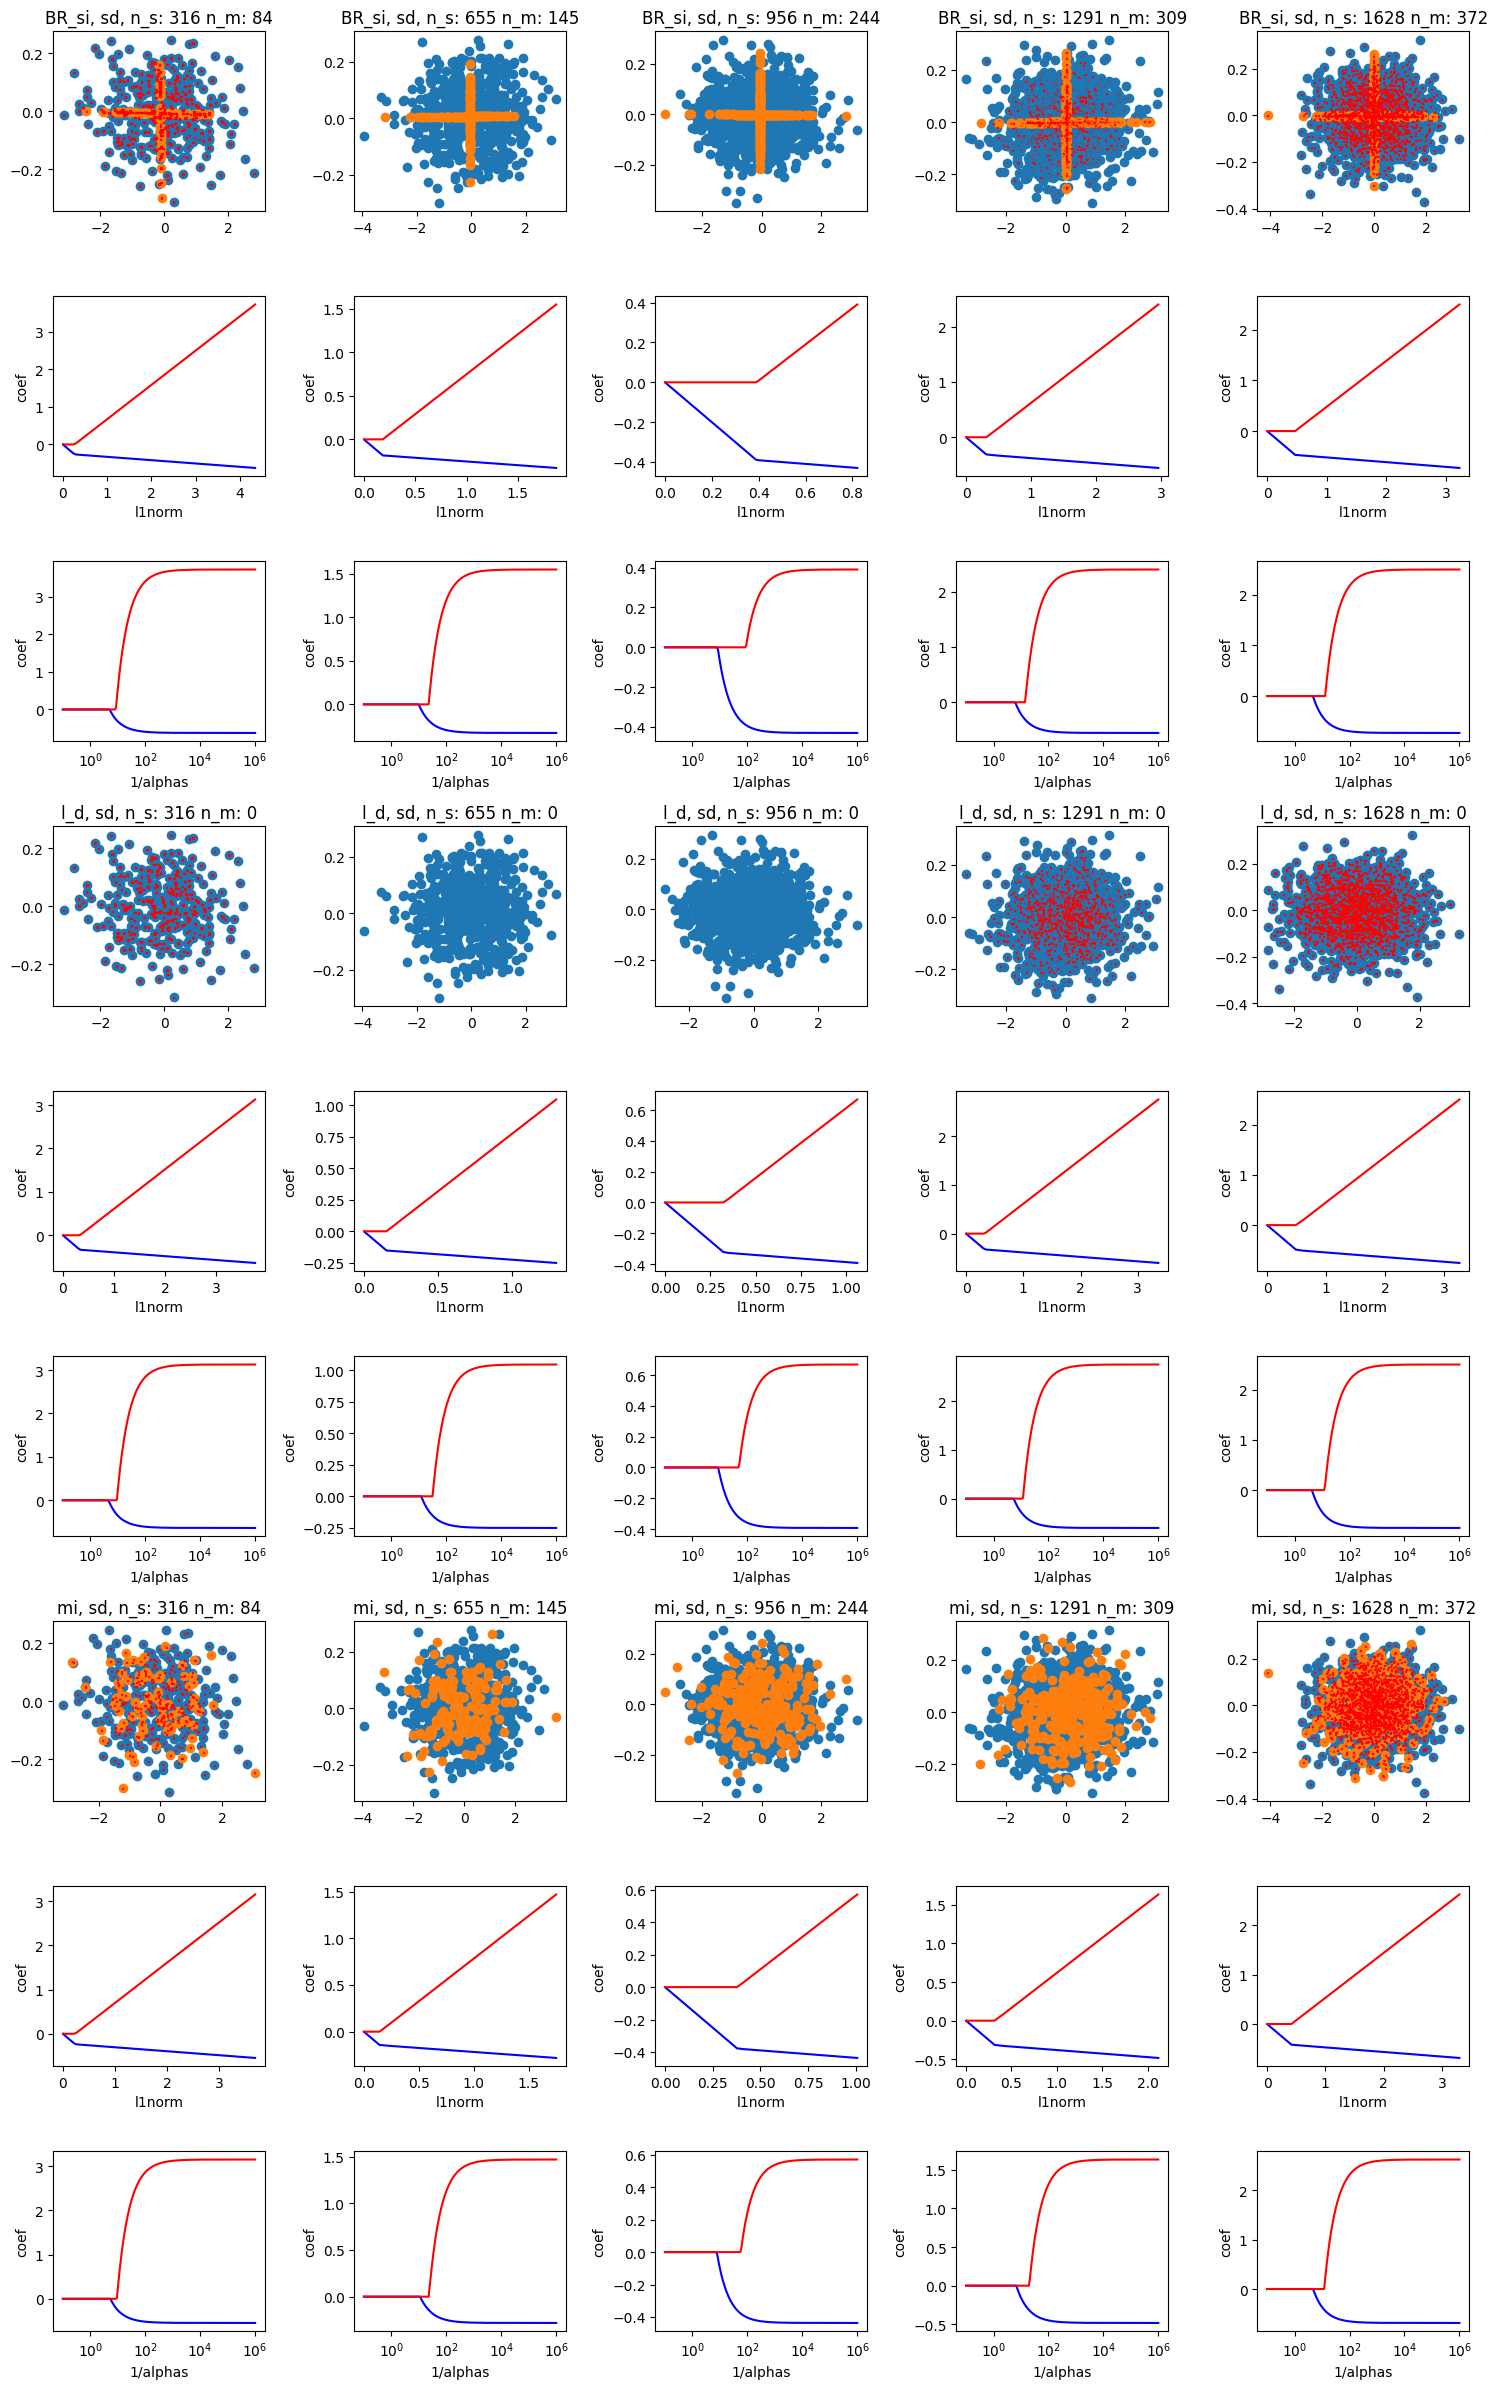

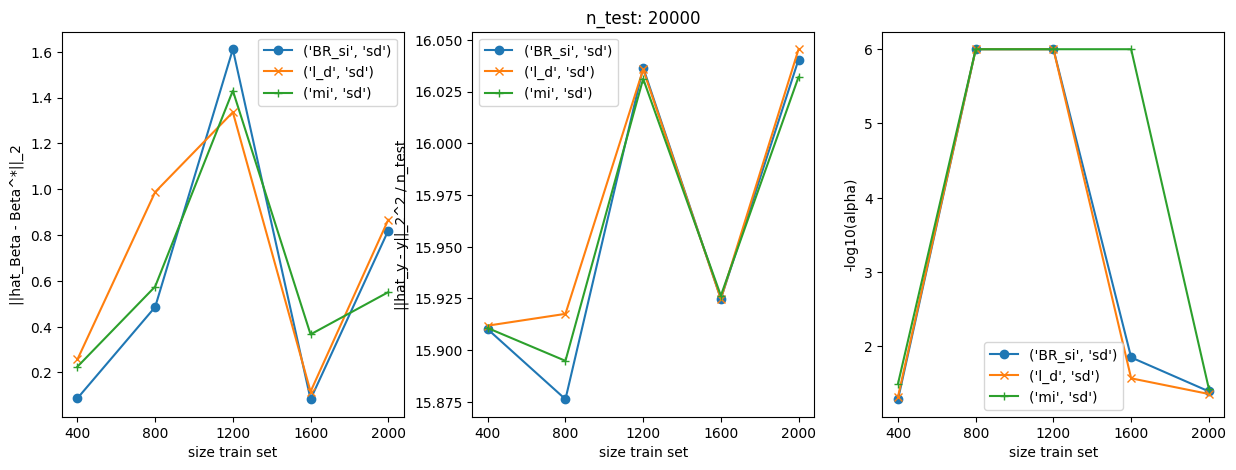

In [109]:
np.random.seed(456)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

info_axis = 'train'  # train or p_seen
n_train = [400, 800, 1200, 1600, 2000]
p_seen_both = [0.8, 0.8, 0.8, 0.8, 0.8]
error_vec =  [4, 4, 4, 4, 4]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)

print("end experiment")
print("COMMENT \n\n high probability of seeing both entries, increasing training set, low error on y \n" +
"train all imputation methods, data are Gaussian unbalanced (data are much more spread on the x axis than on the y axis). \n" +
"The method mi (draws from the posterior) suffer a lot. A possible explaination may be that, given the training set (x, y), with x = (x1, x2), \n" +
"if we suppose to see just the component x1 and we impute x2, it may happen that < x_imputed, beta^*> is very different from ,<x, beta^*> ")



In [110]:
#COMMENT

# high probability of seeing both entries, increasing training set, low error on y
# train all imputation methods, data are Gaussian unbalanced (data are much more spread on the x axis than on the y axis).
# The method mi (draws from the posterior) suffer a lot. A possible explaination may be that, given the training set (x, y), with x = (x1, x2),
# if we suppose to see just the component x1 and we impute x2, it may happen that < x_imputed, beta^*> is very different from ,<x, beta^*>

change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
n_tot :  20400
n_train :  400
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9803921568627451
err :  {'type': 'Gaussian_on_y', 'scaling': 0.1}
p_miss :  [0.1, 0.45, 0.45]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'l_d', 'cov_strategy': 'sd'}, {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}]
imp_method :  BR_si
cov_strategy :  sd
imp_method :  l_d
cov_strategy :  sd
imp_method :  mi
cov_strategy :  sd
mi_nbr :  1
----> Starting experiments
---------------------------------------------------------------------------------------------------------------------------> iteration  0
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20400, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strateg

100%|██████████| 200/200 [00:03<00:00, 61.51it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.012030587120874504
best coeff  [-0.50041293  1.56234641]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  41 nbr_seen (train):  41  nbr_miss :  0
---....---....----....--> diag matrix:  [0.94207567 0.08929292]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 259.88it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.01034731311914482
best coeff  [-0.50212211  1.81315412]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  400 nbr_seen (train):  41  nbr_miss :  359
---....---....----....--> diag matrix:  [0.94577593 0.10438303]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:03<00:00, 61.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.06795881595606923
best coeff  [-0.29226653  0.8273803 ]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20800, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  800 nbr_seen (train):  72  nbr_miss :  728
---....---....----....--> diag matrix:  [0.77659508 0.07349311]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 25.69it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.01024554905811927
best coeff  [-0.48328961  1.88813834]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  72 nbr_seen (train):  72  nbr_miss :  0
---....---....----....--> diag matrix:  [1.0012503  0.09393408]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 151.49it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  140  best 1/best_alpha  11.895340673703208 , min score  0.009920138184038975
best coeff  [-0.49554072  2.02034494]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  800 nbr_seen (train):  72  nbr_miss :  728
---....---....----....--> diag matrix:  [1.06013588 0.09565178]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 26.32it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.07474328937328775
best coeff  [-0.25789569  1.09605054]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21200, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  117  nbr_miss :  1083
---....---....----....--> diag matrix:  [0.74940819 0.0776511 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 25.64it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  130  best 1/best_alpha  26.73841615839949 , min score  0.01096038033967974
best coeff  [-0.4808167   2.21310695]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  117 nbr_seen (train):  117  nbr_miss :  0
---....---....----....--> diag matrix:  [1.04276076 0.09509409]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 119.89it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  142  best 1/best_alpha  10.11637979766207 , min score  0.010354133446206311
best coeff  [-0.4891642   2.10090747]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  117  nbr_miss :  1083
---....---....----....--> diag matrix:  [1.02816007 0.10146888]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 25.88it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.07588023933117982
best coeff  [-0.25344892  1.33259882]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21600, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  175  nbr_miss :  1425
---....---....----....--> diag matrix:  [0.93790424 0.09318799]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 19.88it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  118  best 1/best_alpha  70.67181273927491 , min score  0.06613150488630062
best coeff  [-3.7529343e-01 -3.3257375e-07]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  175 nbr_seen (train):  175  nbr_miss :  0
---....---....----....--> diag matrix:  [1.03005486 0.10086812]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 102.67it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.0101283321654904
best coeff  [-0.49927608  1.97329886]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  175  nbr_miss :  1425
---....---....----....--> diag matrix:  [1.01608206 0.09670385]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:11<00:00, 17.99it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.07742868609650963
best coeff  [-0.26126714  0.9807046 ]
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  197  nbr_miss :  1803
---....---....----....--> diag matrix:  [0.73117923 0.07334191]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 14.27it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.010549959714754337
best coeff  [-0.50333224  1.73981029]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  197 nbr_seen (train):  197  nbr_miss :  0
---....---....----....--> diag matrix:  [0.98770976 0.09576213]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 92.92it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.009975346153635609
best coeff  [-0.4953193  1.9244447]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  197  nbr_miss :  1803
---....---....----....--> diag matrix:  [0.98944133 0.09869217]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.33it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.06866719646337796
best coeff  [-0.28604144  0.88170244]
x_axis---->  [400, 800, 1200, 1600, 2000]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.50041293,  1.56234641]), array([-0.48328961,  1.88813834]), array([-0.4808167 ,  2.21310695]), array([-3.7529343e-01, -3.3257375e-07]), array([-0.50333224,  1.73981029])], 'l2_dist_best_coeff_gt': [np.float64(0.4376537870511462), np.float64(0.11310291204880864), np.float64(0.21396862435014824), np.float64(2.0038844923870456), np.float64(0.26021104810281215)], 'best_score': [np.float64(0.012030587120874504), np.float64(0.01024554905811927), np.float64(0.01096038033967974), np.float64(0.06613150488630062), np.float64(0.010549959714754337)], 'best_alpha': [np.float64(6.0), np.float64(6.0), np.float64(1.4271356783919602), np.float64(1.849246231155779), np.float64(6.0)]}, ('l_d', 'sd'): {'best_coeff': [array([-0.50212211,  1.81315412]), 

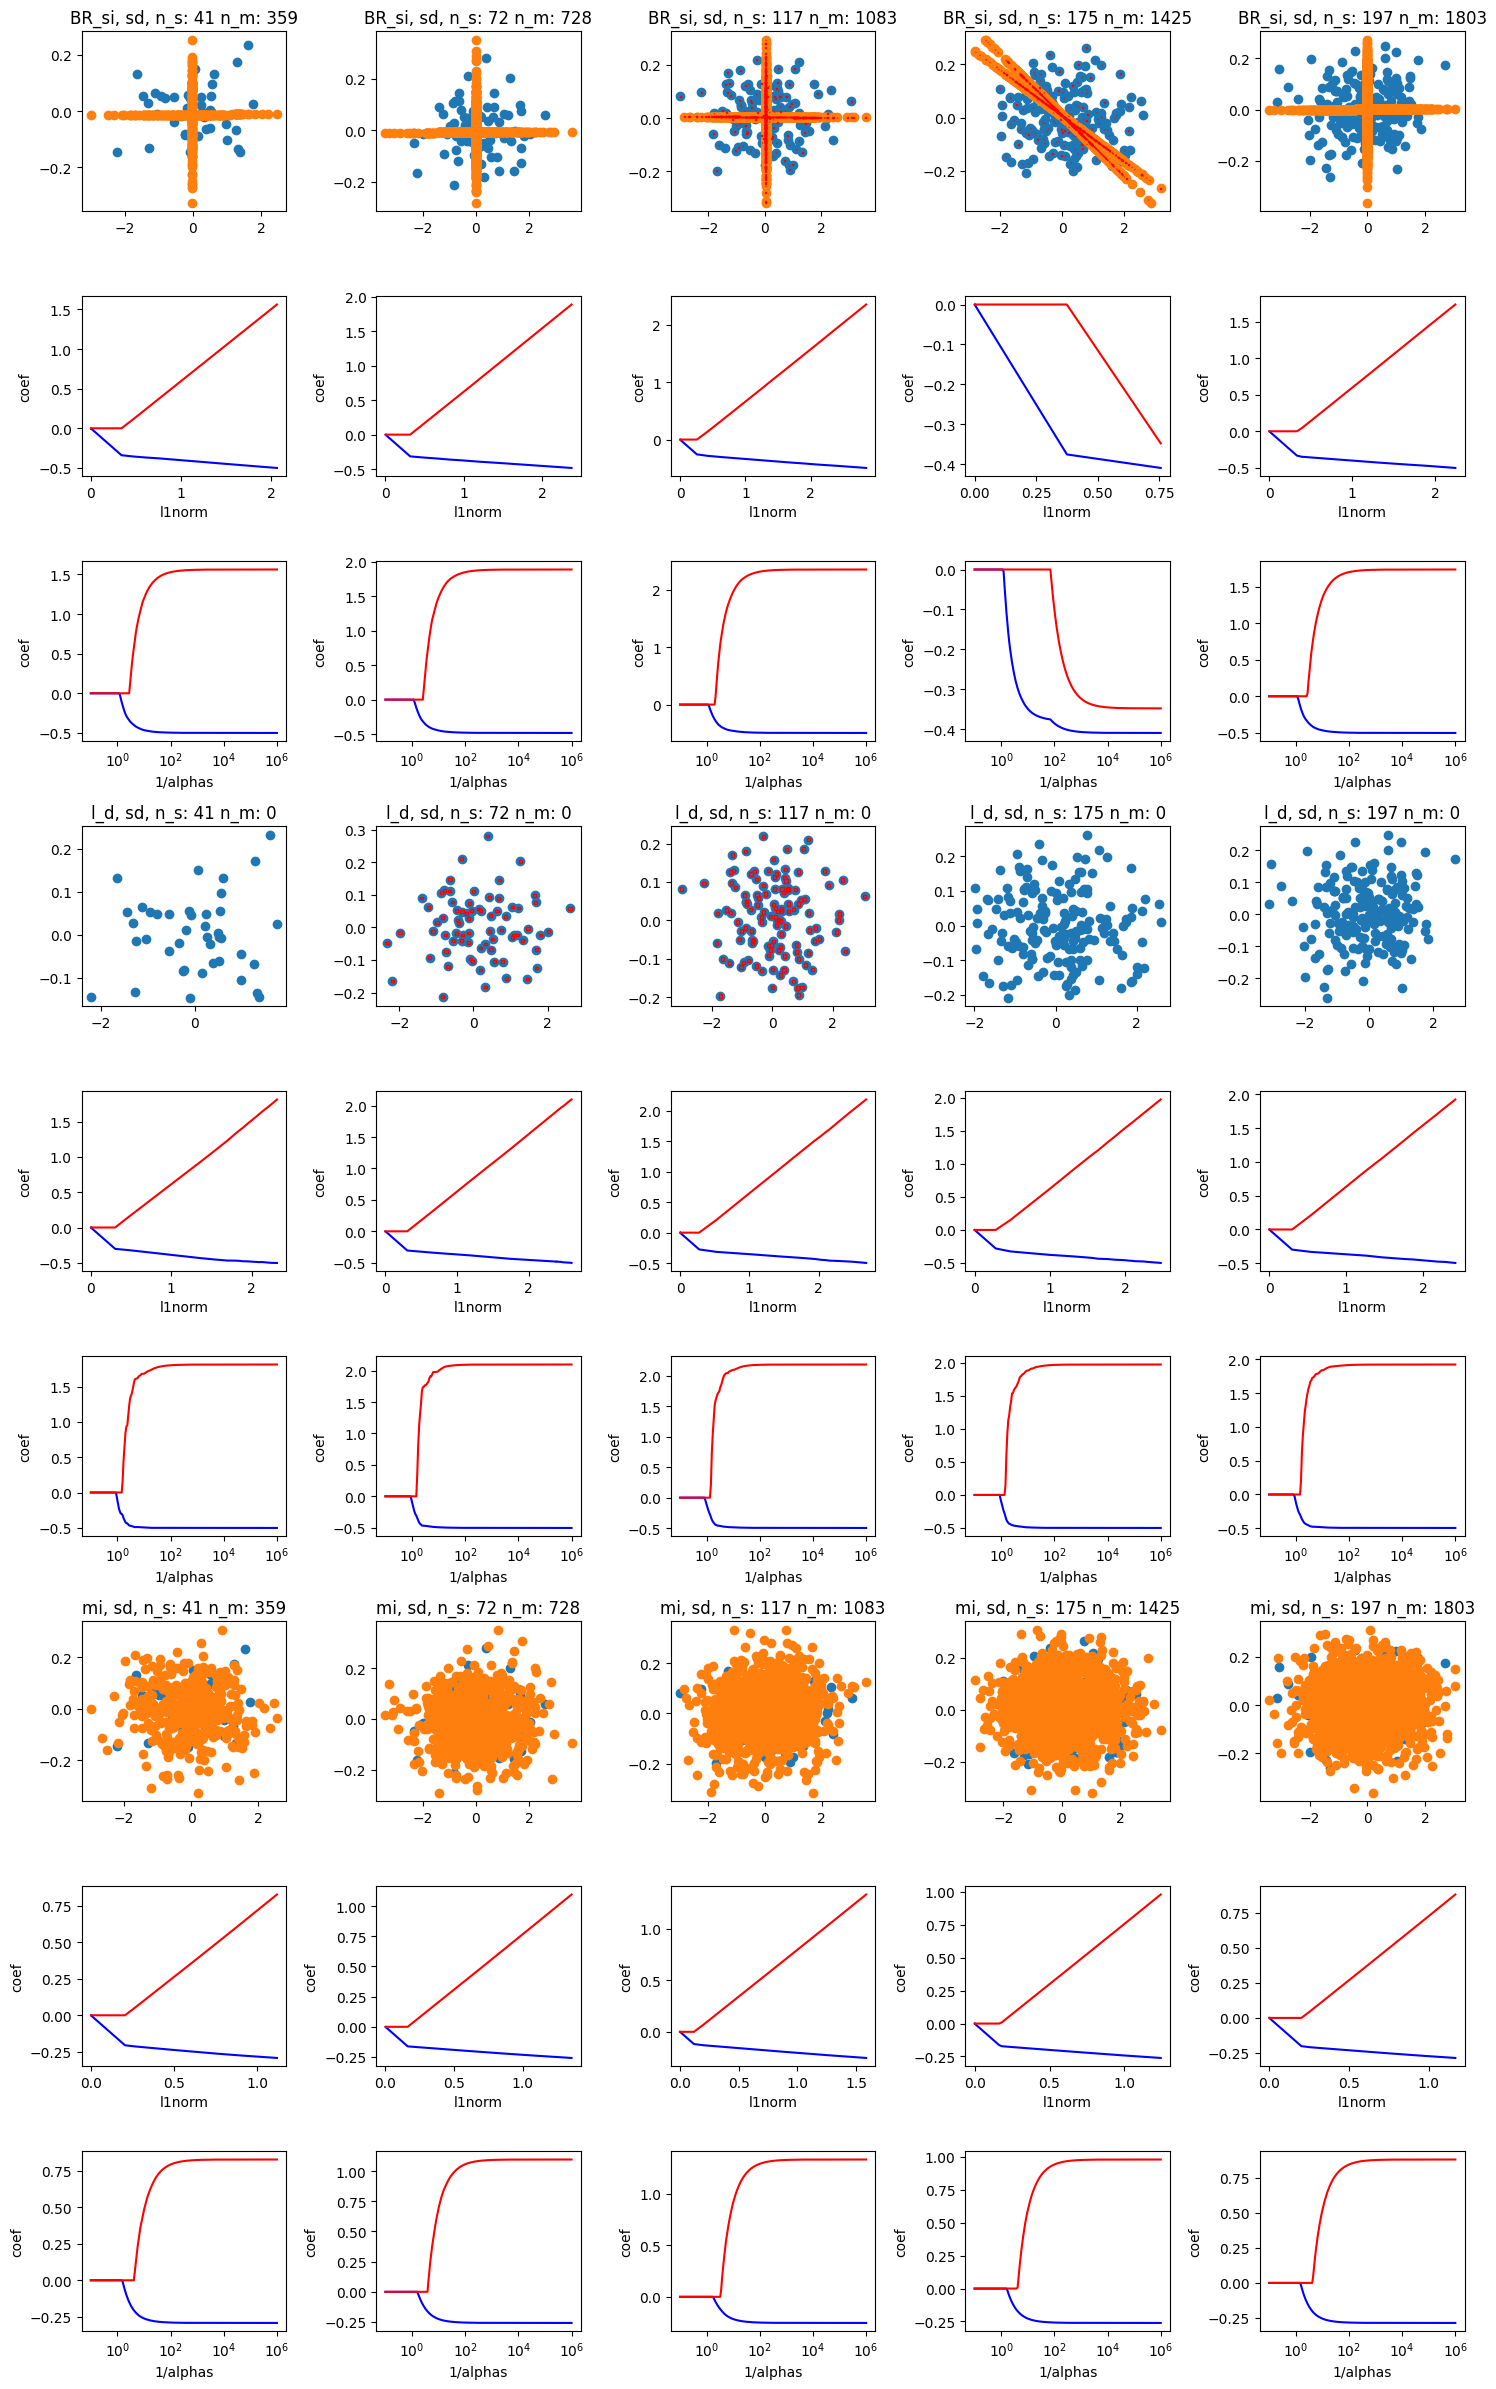

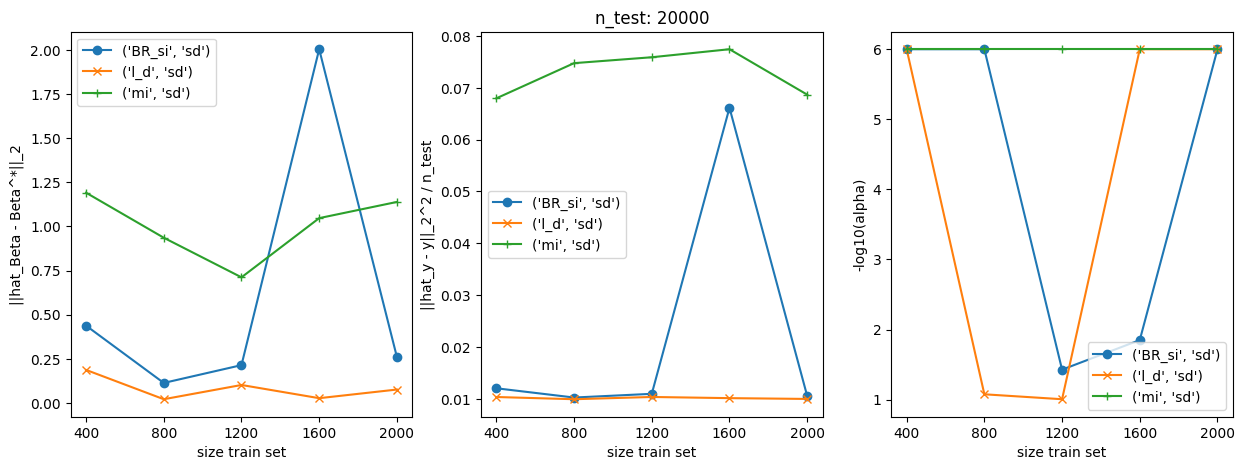

In [111]:
np.random.seed(4567)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.1, 0.1, 0.1, 0.1, 0.1])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

info_axis = 'train'  # train or p_seen
n_train = [400, 800, 1200, 1600, 2000]
p_seen_both = [0.1, 0.1, 0.1, 0.1, 0.1]
error_vec =  [0.1, 0.1, 0.1, 0.1, 0.1]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
print("end experiment")



In [112]:
#"\n\n COMMENTS \n the setting is as the one above, with a much lower probability of seen both components, i.e. 0.1
# We can clarily see in one the plot the importance of the quality of imputation.
# With Gaussian data, it looks that a good imputation is the imputation by 0, and different impuation skew too much the relation between X and the response y

change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
n_tot :  20400
n_train :  400
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9803921568627451
err :  {'type': 'Gaussian_on_y', 'scaling': 8}
p_miss :  [0.8, 0.09999999999999998, 0.09999999999999998]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'l_d', 'cov_strategy': 'sd'}, {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}]
imp_method :  BR_si
cov_strategy :  sd
imp_method :  l_d
cov_strategy :  sd
imp_method :  mi
cov_strategy :  sd
mi_nbr :  1
----> Starting experiments
---------------------------------------------------------------------------------------------------------------------------> iteration  0
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20400, 2)
----------------------------------------------> new method tested:  {'imp_me

100%|██████████| 200/200 [00:03<00:00, 66.33it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  134  best 1/best_alpha  19.33891750455232 , min score  63.64033944043892
best coeff  [-0.42999587  2.2001412 ]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  316 nbr_seen (train):  316  nbr_miss :  0
---....---....----....--> diag matrix:  [1.06154924 0.10427616]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 79.53it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  133  best 1/best_alpha  20.97046401323231 , min score  63.647046065636005
best coeff  [-0.50733117  1.5021692 ]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  400 nbr_seen (train):  316  nbr_miss :  84
---....---....----....--> diag matrix:  [1.05431508 0.10456691]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:03<00:00, 65.74it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  130  best 1/best_alpha  26.73841615839949 , min score  63.642811757512845
best coeff  [-0.41547385  2.54297913]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20800, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  800 nbr_seen (train):  655  nbr_miss :  145
---....---....----....--> diag matrix:  [1.00173565 0.09260641]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:06<00:00, 29.65it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  63.501924902039164
best coeff  [-0.15718969  1.14669235]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  655 nbr_seen (train):  655  nbr_miss :  0
---....---....----....--> diag matrix:  [1.05299633 0.09839187]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:05<00:00, 39.48it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  63.67004203211066
best coeff  [-0.00149794  0.08874986]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  800 nbr_seen (train):  655  nbr_miss :  145
---....---....----....--> diag matrix:  [1.0452136  0.09735286]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 25.64it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  63.53156715726138
best coeff  [-0.11389954  1.15848649]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21200, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  956  nbr_miss :  244
---....---....----....--> diag matrix:  [0.8963578  0.09083671]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 26.08it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  114  best 1/best_alpha  97.71241535346502 , min score  64.13879180189541
best coeff  [-0.28255682 -0.54388368]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  956 nbr_seen (train):  956  nbr_miss :  0
---....---....----....--> diag matrix:  [0.95380806 0.09625048]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 26.03it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  90  best 1/best_alpha  682.6071834272386 , min score  64.14261274035701
best coeff  [-0.27485125 -0.56173736]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  956  nbr_miss :  244
---....---....----....--> diag matrix:  [0.95029948 0.09547303]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 24.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  113  best 1/best_alpha  105.9560179277616 , min score  64.09703822919444
best coeff  [-0.35231976 -0.00457465]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21600, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  1291  nbr_miss :  309
---....---....----....--> diag matrix:  [0.9454241  0.09455371]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 18.21it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  118  best 1/best_alpha  70.67181273927491 , min score  63.69911236070596
best coeff  [-0.51444312  1.82860926]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1291 nbr_seen (train):  1291  nbr_miss :  0
---....---....----....--> diag matrix:  [0.98882417 0.09975737]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.96it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  126  best 1/best_alpha  36.96912707195025 , min score  63.699119982579944
best coeff  [-0.52926031  1.76808948]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  1291  nbr_miss :  309
---....---....----....--> diag matrix:  [0.98395095 0.09937612]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:11<00:00, 18.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  63.70061632244273
best coeff  [-0.50099001  1.48131751]
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1628  nbr_miss :  372
---....---....----....--> diag matrix:  [0.94166192 0.09642264]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.90it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  137  best 1/best_alpha  15.167168884709241 , min score  64.14754994085412
best coeff  [-5.20212015e-01  7.84390345e-09]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1628 nbr_seen (train):  1628  nbr_miss :  0
---....---....----....--> diag matrix:  [0.99223412 0.10112215]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:11<00:00, 18.02it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  139  best 1/best_alpha  12.89890261253308 , min score  64.14751224727819
best coeff  [-5.15211471e-01  2.67695134e-09]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1628  nbr_miss :  372
---....---....----....--> diag matrix:  [0.99173649 0.10150883]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.96it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  131  best 1/best_alpha  24.65811075822604 , min score  64.13545647269841
best coeff  [-0.65918443  0.887471  ]
x_axis---->  [400, 800, 1200, 1600, 2000]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.42999587,  2.2001412 ]), array([-0.15718969,  1.14669235]), array([-0.28255682, -0.54388368]), array([-0.51444312,  1.82860926]), array([-5.20212015e-01,  7.84390345e-09])], 'l2_dist_best_coeff_gt': [np.float64(0.21203083949468518), np.float64(0.9195938570804482), np.float64(2.553159951295161), np.float64(0.17199822483077576), np.float64(2.0001021209376297)], 'best_score': [np.float64(63.64033944043892), np.float64(63.501924902039164), np.float64(64.13879180189541), np.float64(63.69911236070596), np.float64(64.14754994085412)], 'best_alpha': [np.float64(1.2864321608040203), np.float64(6.0), np.float64(1.9899497487437188), np.float64(1.849246231155779), np.float64(1.1809045226130657)]}, ('l_d', 'sd'): {'best_coeff': [array([-

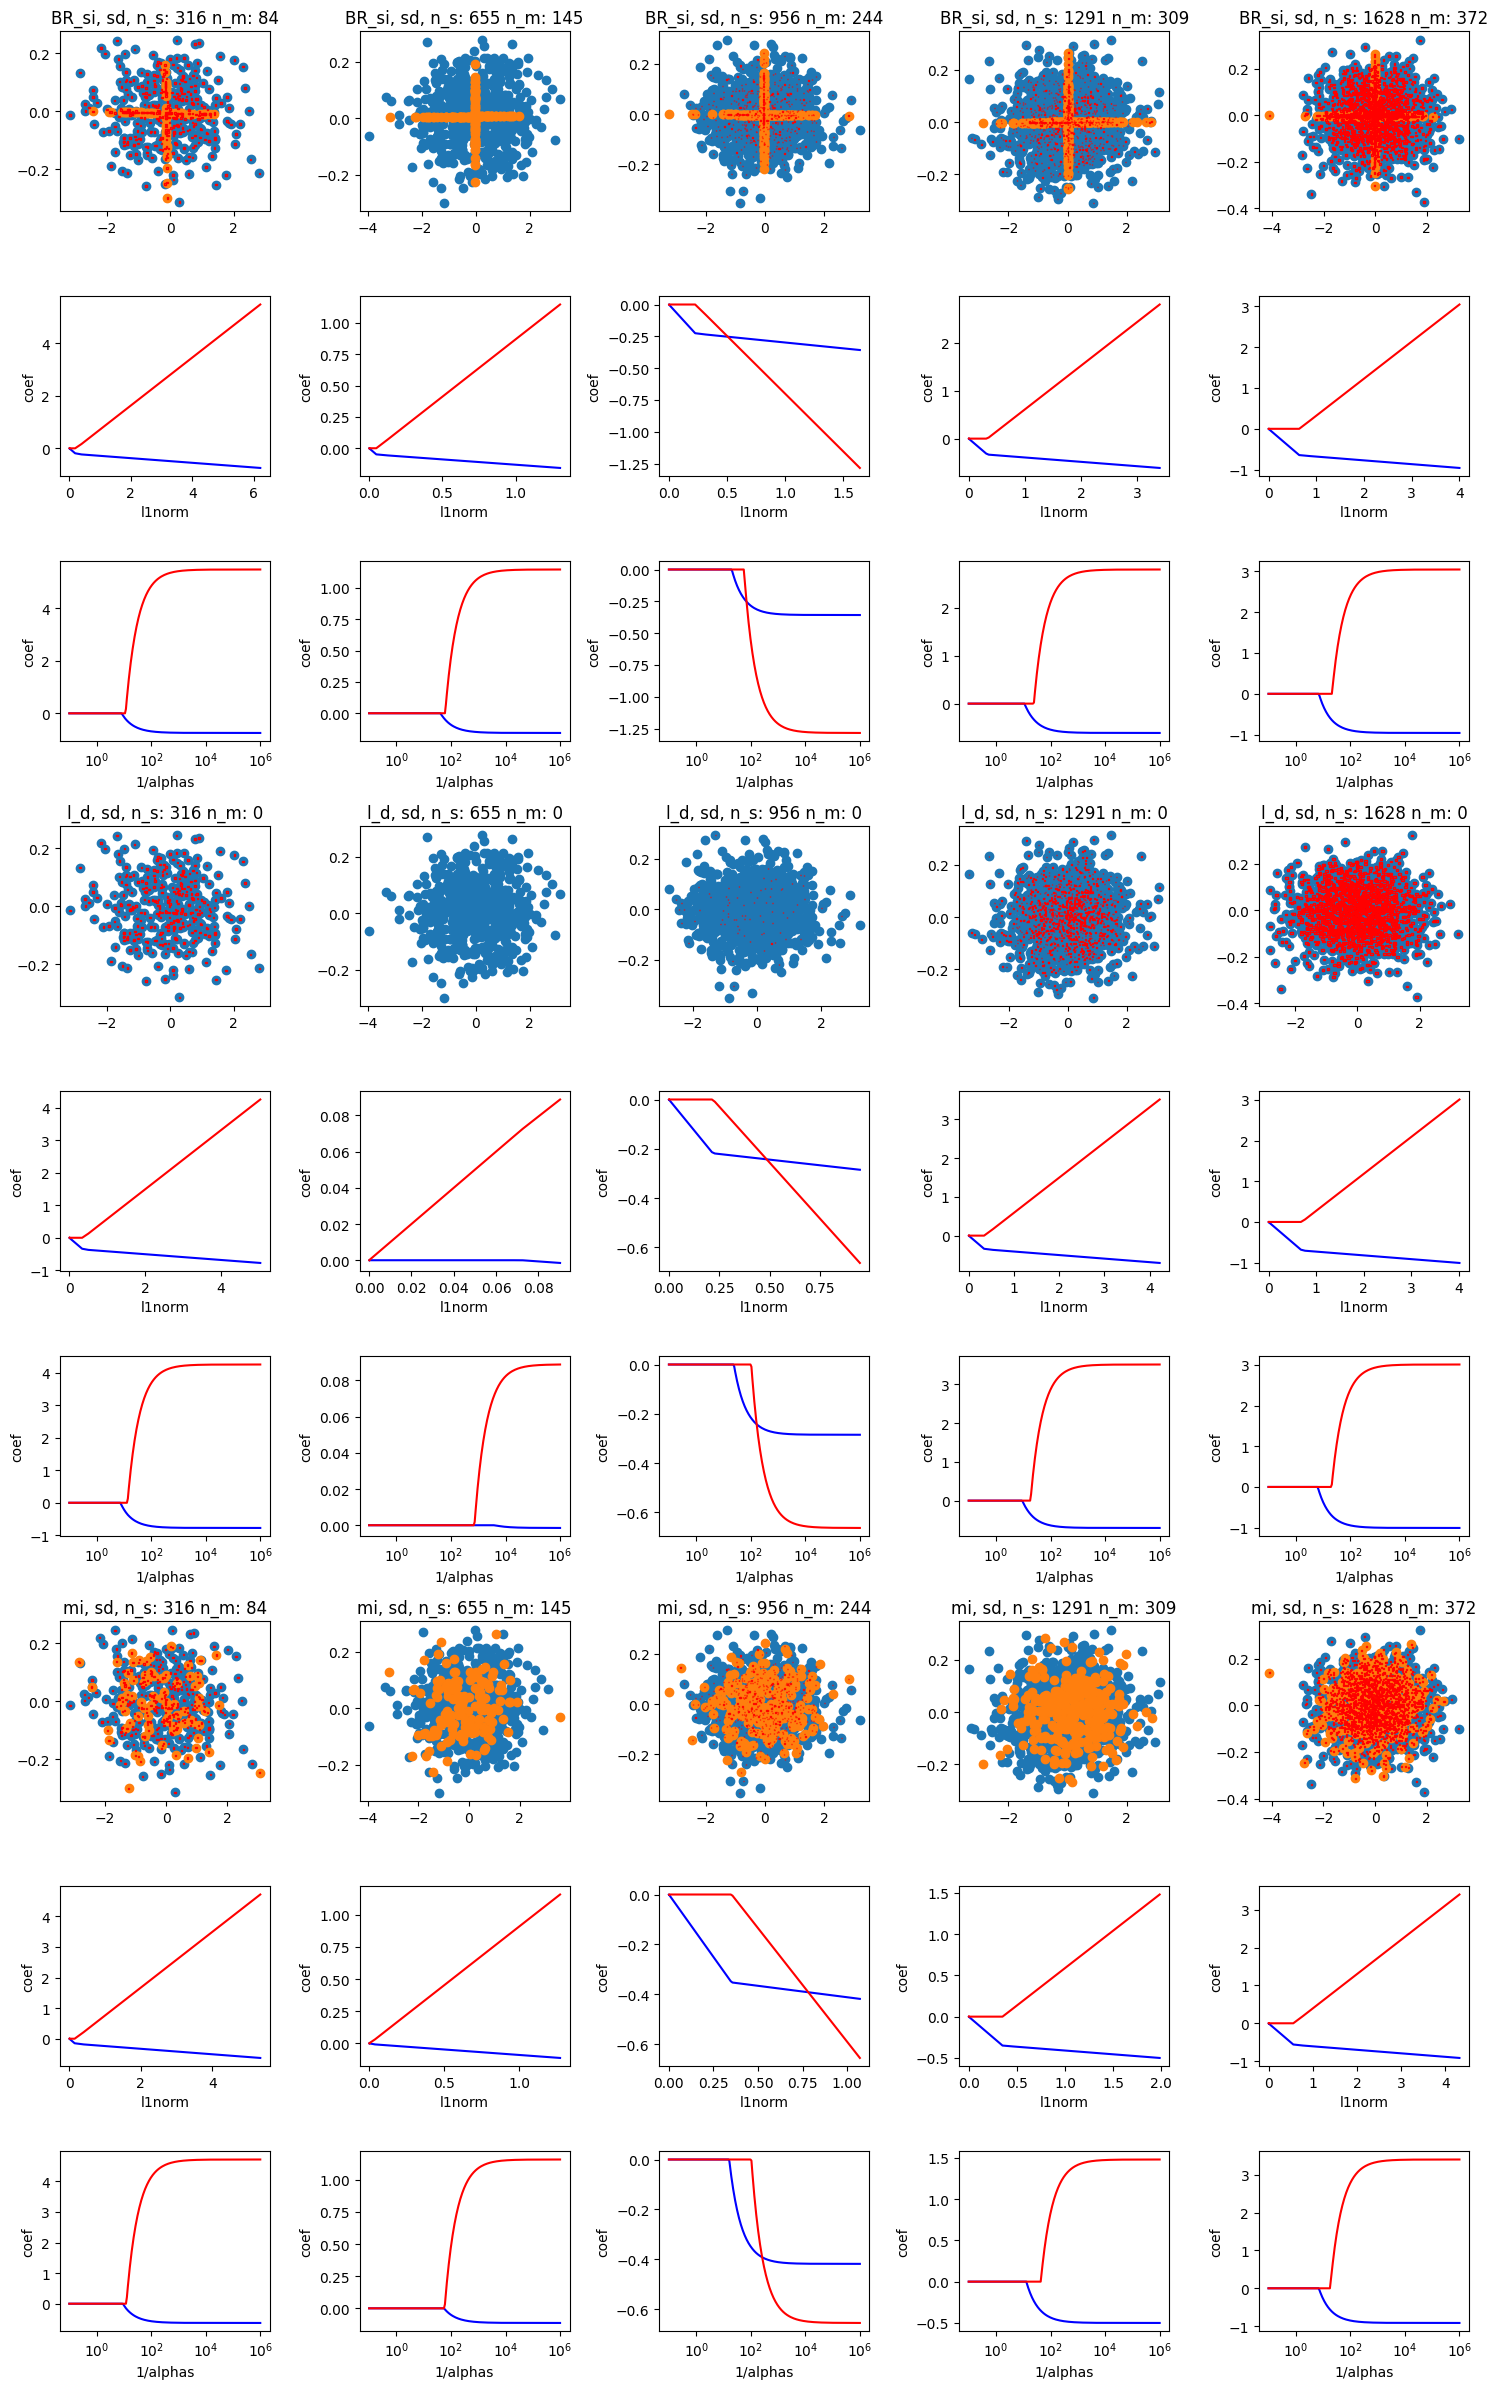

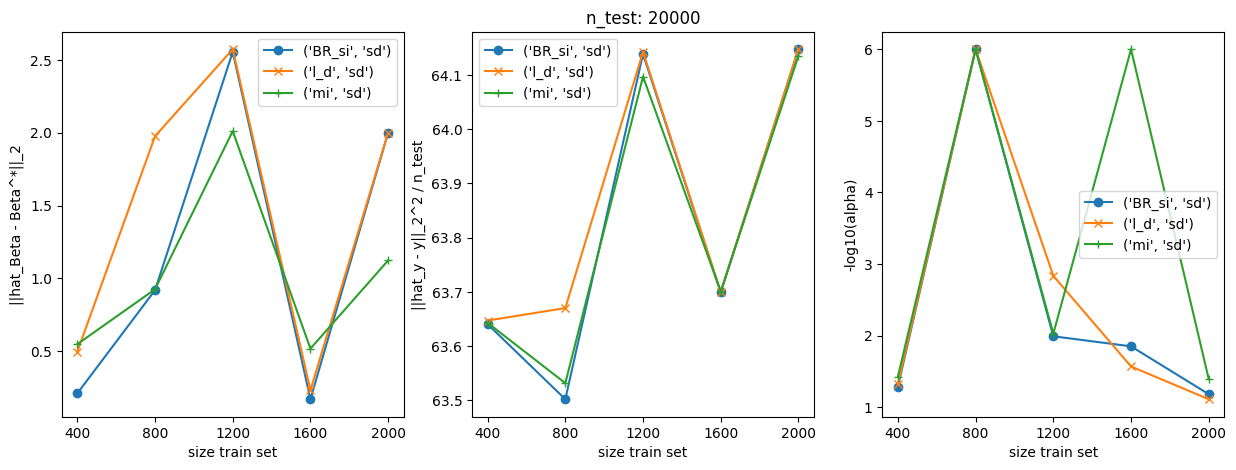

In [113]:
np.random.seed(456)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)


info_axis = 'train'  # train or p_seen
n_train = [400, 800, 1200, 1600, 2000]
p_seen_both = [0.8, 0.8, 0.8, 0.8, 0.8]
error_vec =  [8, 8, 8, 8, 8]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)



dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)




In [114]:
#print("end experiment")
#print("COMMENT \n\n high probability of seeing both entries, increasing training set, high error on y \n" +
#"train all imputation methods, data are Gaussian unbalanced (data are much more spread on the x axis than on the y axis). \n" +

# here the error is very high. Observe that, even though it look like that the solution are far from each other (particularly in size 1600 and 2000), the error on the training set looks the same
# it looks that overall mi perform better than the other method with high noise

change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
n_tot :  20400
n_train :  400
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9803921568627451
err :  {'type': 'Gaussian_on_y', 'scaling': 8}
p_miss :  [0.1, 0.45, 0.45]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'l_d', 'cov_strategy': 'sd'}, {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}]
imp_method :  BR_si
cov_strategy :  sd
imp_method :  l_d
cov_strategy :  sd
imp_method :  mi
cov_strategy :  sd
mi_nbr :  1
----> Starting experiments


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


---------------------------------------------------------------------------------------------------------------------------> iteration  0
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20400, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  400 nbr_seen (train):  32  nbr_miss :  368
---....---....----....--> diag matrix:  [1.03822662 0.10287409]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:03<00:00, 62.31it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  119  best 1/best_alpha  65.1733960488242 , min score  63.64320815675805
best coeff  [-0.44280813  1.55754165]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  32 nbr_seen (train):  32  nbr_miss :  0
---....---....----....--> diag matrix:  [0.9938854  0.09200427]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 195.99it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  160  best 1/best_alpha  2.3542864143224205 , min score  63.68777224563246
best coeff  [-4.04187898e-01 -9.57958440e-09]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  400 nbr_seen (train):  32  nbr_miss :  368
---....---....----....--> diag matrix:  [1.04157299 0.1057766 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:03<00:00, 60.79it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  127  best 1/best_alpha  34.092850697468144 , min score  63.68545342286325
best coeff  [-4.45544668e-01  2.65159753e-08]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20800, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  800 nbr_seen (train):  92  nbr_miss :  708
---....---....----....--> diag matrix:  [0.97106182 0.09407937]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 27.63it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  120  best 1/best_alpha  60.10276782070388 , min score  63.921261392183965
best coeff  [-0.23491493  4.52716244]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  92 nbr_seen (train):  92  nbr_miss :  0
---....---....----....--> diag matrix:  [1.00851014 0.09387199]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 168.28it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  145  best 1/best_alpha  7.934096665797491 , min score  64.04973872543523
best coeff  [-1.38544459e-09  2.22565085e+00]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  800 nbr_seen (train):  92  nbr_miss :  708
---....---....----....--> diag matrix:  [0.97155365 0.09987293]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:06<00:00, 30.17it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  119  best 1/best_alpha  65.1733960488242 , min score  63.853079126443355
best coeff  [-0.35127817  3.73162072]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21200, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  113  nbr_miss :  1087
---....---....----....--> diag matrix:  [0.74055597 0.07446643]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 25.35it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  131  best 1/best_alpha  24.65811075822604 , min score  63.32307772658295
best coeff  [5.63048038e-11 1.66528565e+00]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  113 nbr_seen (train):  113  nbr_miss :  0
---....---....----....--> diag matrix:  [1.0102846  0.09579492]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 153.72it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  189  best 1/best_alpha  0.22478058335487255 , min score  63.35286329870061
best coeff  [-5.93808154e-12  9.68334455e-11]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  113  nbr_miss :  1087
---....---....----....--> diag matrix:  [0.99775891 0.10146985]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 26.19it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  136  best 1/best_alpha  16.446761779946627 , min score  63.32323444916358
best coeff  [8.14315446e-12 1.88635070e+00]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21600, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  155  nbr_miss :  1445
---....---....----....--> diag matrix:  [0.92102625 0.10112978]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 18.46it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  126  best 1/best_alpha  36.96912707195025 , min score  63.40767029720277
best coeff  [2.16036045e-11 2.30135323e+00]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  155 nbr_seen (train):  155  nbr_miss :  0
---....---....----....--> diag matrix:  [0.93111451 0.10619803]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 107.81it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  151  best 1/best_alpha  4.880251583654434 , min score  63.41045546953633
best coeff  [1.26314490e-10 2.78214446e+00]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1600 nbr_seen (train):  155  nbr_miss :  1445
---....---....----....--> diag matrix:  [0.98084612 0.10469386]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 20.76it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  63.331595488336276
best coeff  [-0.13470454 -0.09882924]
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  183  nbr_miss :  1817
---....---....----....--> diag matrix:  [0.72714005 0.07508653]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.39it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  64.06977055065023
best coeff  [-0.16527338  0.82508326]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  183 nbr_seen (train):  183  nbr_miss :  0
---....---....----....--> diag matrix:  [0.97334087 0.10307878]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 101.88it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  117  best 1/best_alpha  76.63410868007463 , min score  64.10618069413303
best coeff  [-0.22199497  5.32400569]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  183  nbr_miss :  1817
---....---....----....--> diag matrix:  [0.97384932 0.10370024]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.51it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  64.05501886941765
best coeff  [-0.19868868  0.60296269]
x_axis---->  [400, 800, 1200, 1600, 2000]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.44280813,  1.55754165]), array([-0.23491493,  4.52716244]), array([5.63048038e-11, 1.66528565e+00]), array([2.16036045e-11, 2.30135323e+00]), array([-0.16527338,  0.82508326])], 'l2_dist_best_coeff_gt': [np.float64(0.44613933306245007), np.float64(2.541027370614634), np.float64(0.6016923591828508), np.float64(0.5837925717032998), np.float64(1.221667410878105)], 'best_score': [np.float64(63.64320815675805), np.float64(63.921261392183965), np.float64(63.32307772658295), np.float64(63.40767029720277), np.float64(64.06977055065023)], 'best_alpha': [np.float64(1.8140703517587937), np.float64(1.7788944723618094), np.float64(1.391959798994975), np.float64(1.5678391959798992), np.float64(6.0)]}, ('l_d', 'sd'): {'best_coeff': [array([-4.041878

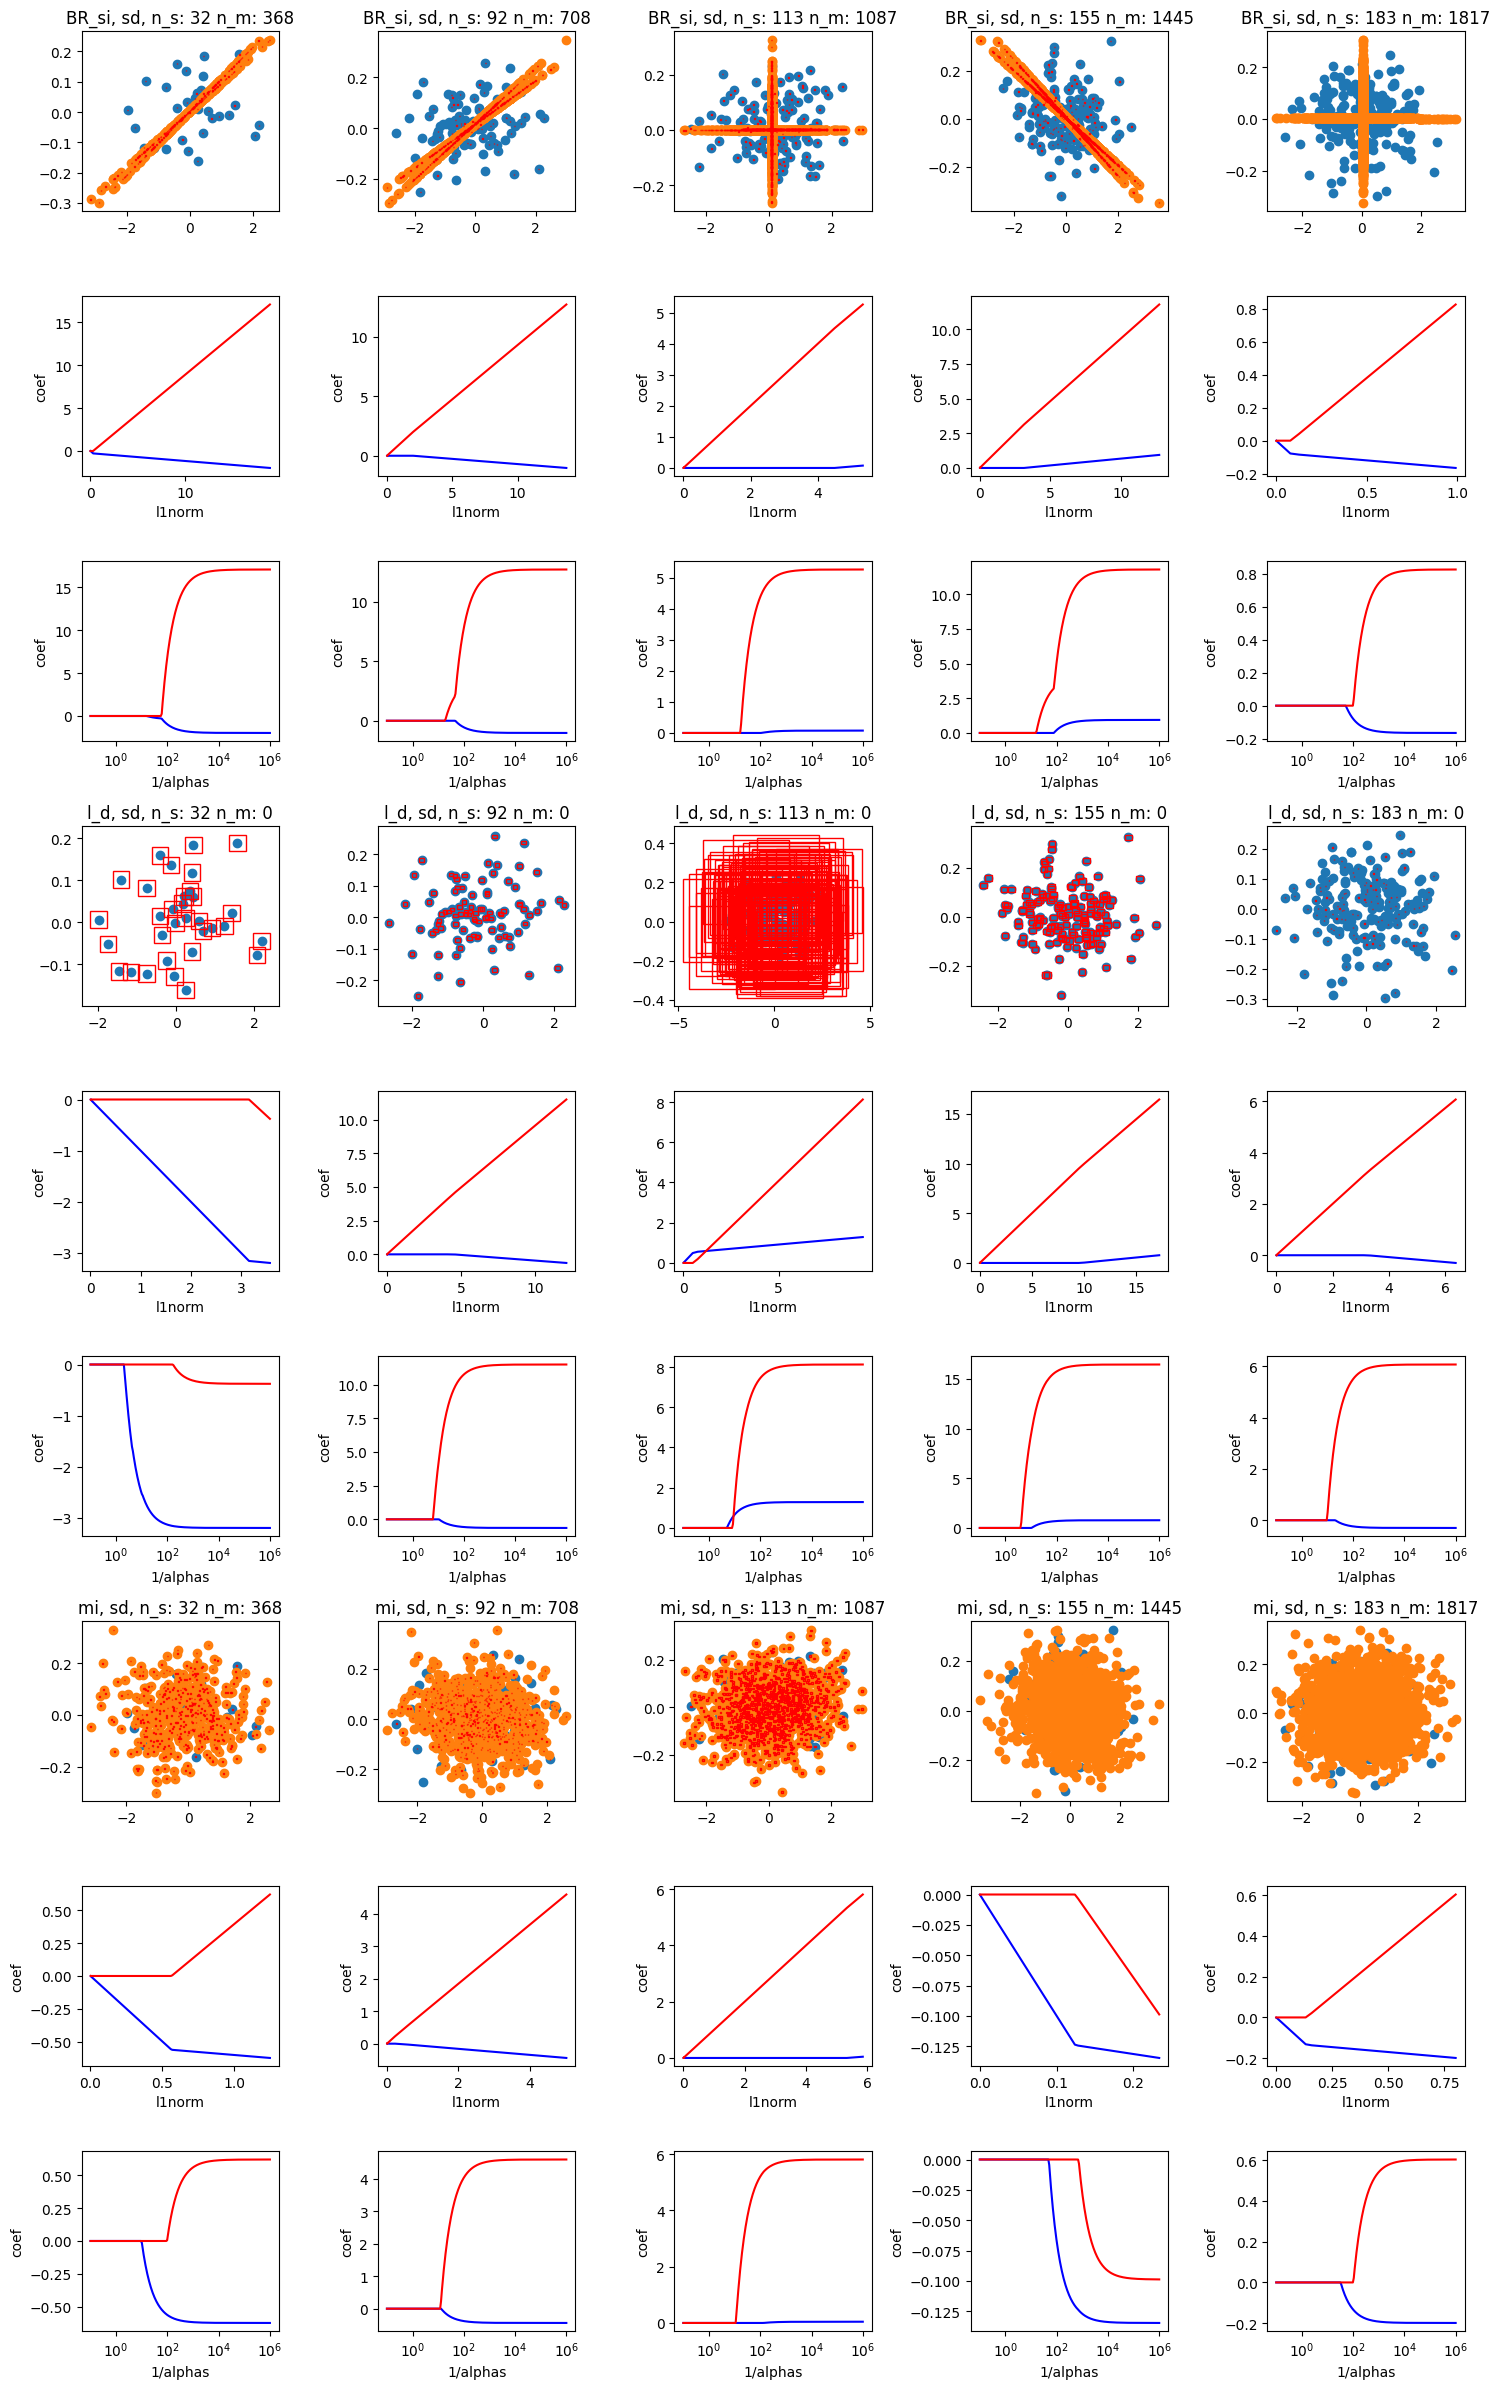

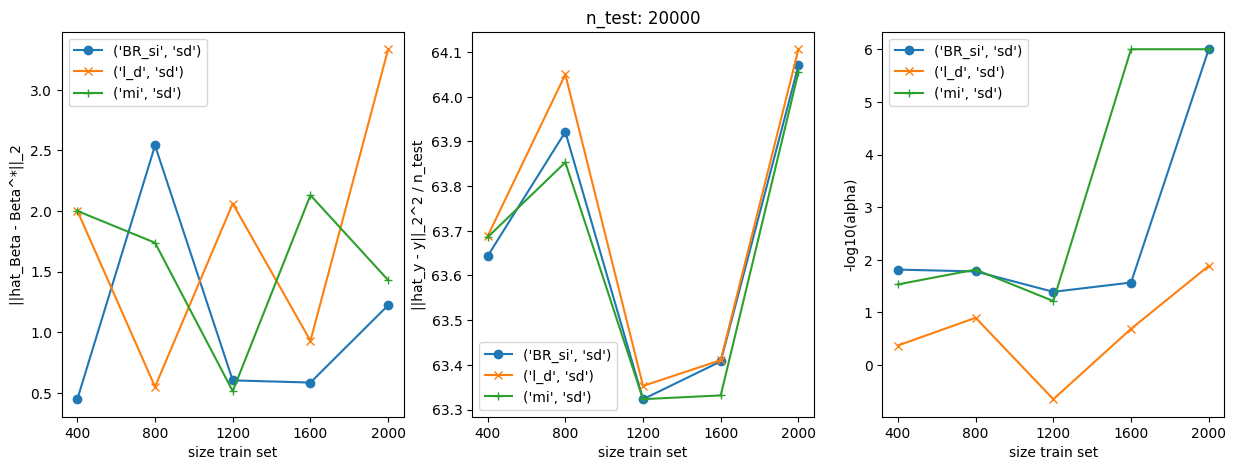

In [115]:
np.random.seed(456)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.1, 0.1, 0.1, 0.1, 0.1])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

info_axis = 'train'  # train or p_seen
n_train = [400, 800, 1200, 1600, 2000]
p_seen_both = [0.1, 0.1, 0.1, 0.1, 0.1]
error_vec =  [8, 8, 8, 8, 8]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)




In [ ]:
np.random.seed(456)

#info_axis = 'p_seen'  # train or p_seen
#n_train = [2000, 2000, 2000, 2000, 2000]
#p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
#p_seen = make_probabilities(p_seen_both)
#main_vec = n_train if info_axis == 'train' else p_seen_both
#info_x_axis = make_info_axis(main_vec, info_axis)

info_axis = 'p_seen'  # train or p_seen or error
n_train = [2000, 2000, 2000, 2000, 2000]
p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
error_vec =  [4, 4, 4, 4, 4]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



In [117]:
# COMMENTS

# error_on_y is mild, percentace of seen decrease from mild to very low.
# We can see the trend on the test error goes from being decreasing (slightly) to increase when the percentage of missing is very high
# Interestingly, decreasing the percentafe of fully seen does not automatically implies worse performance, at least when the percentafe of missing is not very high

change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
n_tot :  22000
n_train :  2000
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9090909090909091
err :  {'type': 'Gaussian_on_y', 'scaling': 2.5}
p_miss :  [0.6, 0.2, 0.2]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'l_d', 'cov_strategy': 'sd'}, {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}]
imp_method :  BR_si
cov_strategy :  sd
imp_method :  l_d
cov_strategy :  sd
imp_method :  mi
cov_strategy :  sd
mi_nbr :  1
----> Starting experiments
---------------------------------------------------------------------------------------------------------------------------> iteration  0
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy

100%|██████████| 200/200 [00:13<00:00, 14.67it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.244895106748866
best coeff  [-0.49606177  1.17532186]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1226 nbr_seen (train):  1226  nbr_miss :  0
---....---....----....--> diag matrix:  [0.99441068 0.10043835]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 22.18it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.242729710706549
best coeff  [-0.50499227  1.29723304]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1226  nbr_miss :  774
---....---....----....--> diag matrix:  [1.00305729 0.10194773]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.267636974475023
best coeff  [-0.38016983  0.92309916]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  798  nbr_miss :  1202
---....---....----....--> diag matrix:  [0.84625294 0.0822144 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  72  best 1/best_alpha  2933.1662783900456 , min score  6.197880178103028
best coeff  [-0.54697425  1.42347921]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  798 nbr_seen (train):  798  nbr_miss :  0
---....---....----....--> diag matrix:  [1.03176277 0.09633839]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 26.47it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  118  best 1/best_alpha  70.67181273927491 , min score  6.195296863818876
best coeff  [-0.52293567  1.68156998]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  798  nbr_miss :  1202
---....---....----....--> diag matrix:  [0.98817849 0.09728889]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.71it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.222997508868689
best coeff  [-0.39508959  0.58197948]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  394  nbr_miss :  1606
---....---....----....--> diag matrix:  [0.77488198 0.07669345]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.51it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  125  best 1/best_alpha  40.08806328898464 , min score  6.19175784166509
best coeff  [-0.48563948  2.25976068]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  394 nbr_seen (train):  394  nbr_miss :  0
---....---....----....--> diag matrix:  [1.02115928 0.09849016]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:03<00:00, 64.83it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  116  best 1/best_alpha  83.09941949353387 , min score  6.19383823444872
best coeff  [-0.45215332  2.52619238]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  394  nbr_miss :  1606
---....---....----....--> diag matrix:  [1.00724238 0.10044463]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.36it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.217292932446189
best coeff  [-0.32637823  2.02018137]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  211  nbr_miss :  1789
---....---....----....--> diag matrix:  [0.75180477 0.07021302]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.04it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.205702168616297
best coeff  [-0.45288755  1.53706948]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  211 nbr_seen (train):  211  nbr_miss :  0
---....---....----....--> diag matrix:  [1.04420399 0.09044008]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 87.08it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  123  best 1/best_alpha  47.13753134116729 , min score  6.23625406545913
best coeff  [-0.62572346  0.71926791]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  211  nbr_miss :  1789
---....---....----....--> diag matrix:  [1.01385553 0.09374727]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.75it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.280502784120541
best coeff  [-0.23062341  0.83131333]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  39  nbr_miss :  1961
---....---....----....--> diag matrix:  [0.96013284 0.1075206 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.68it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  96  best 1/best_alpha  419.870708444391 , min score  6.393202294988042
best coeff  [-3.46651235e-01 -4.53624090e-06]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  39 nbr_seen (train):  39  nbr_miss :  0
---....---....----....--> diag matrix:  [1.00903652 0.10114417]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 258.83it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  170  best 1/best_alpha  1.0473708979594487 , min score  6.610561708656386
best coeff  [-6.24214521e-11 -8.13318222e-10]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  39  nbr_miss :  1961
---....---....----....--> diag matrix:  [1.00915146 0.10182928]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.08it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  6.430236356456791
best coeff  [-0.21187521  0.58117494]
x_axis---->  [0.6, 0.4, 0.2, 0.1, 0.02]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.49606177,  1.17532186]), array([-0.54697425,  1.42347921]), array([-0.48563948,  2.25976068]), array([-0.45288755,  1.53706948]), array([-3.46651235e-01, -4.53624090e-06])], 'l2_dist_best_coeff_gt': [np.float64(0.8246875389387044), np.float64(0.5784313246451879), np.float64(0.2601573294725824), np.float64(0.46532166714475776), np.float64(2.005874868680242)], 'best_score': [np.float64(6.244895106748866), np.float64(6.197880178103028), np.float64(6.19175784166509), np.float64(6.205702168616297), np.float64(6.393202294988042)], 'best_alpha': [np.float64(6.0), np.float64(3.4673366834170856), np.float64(1.6030150753768844), np.float64(6.0), np.float64(2.6231155778894473)]}, ('l_d', 'sd'): {'best_coeff': [array([-0.50499227,  1.29723304]), ar

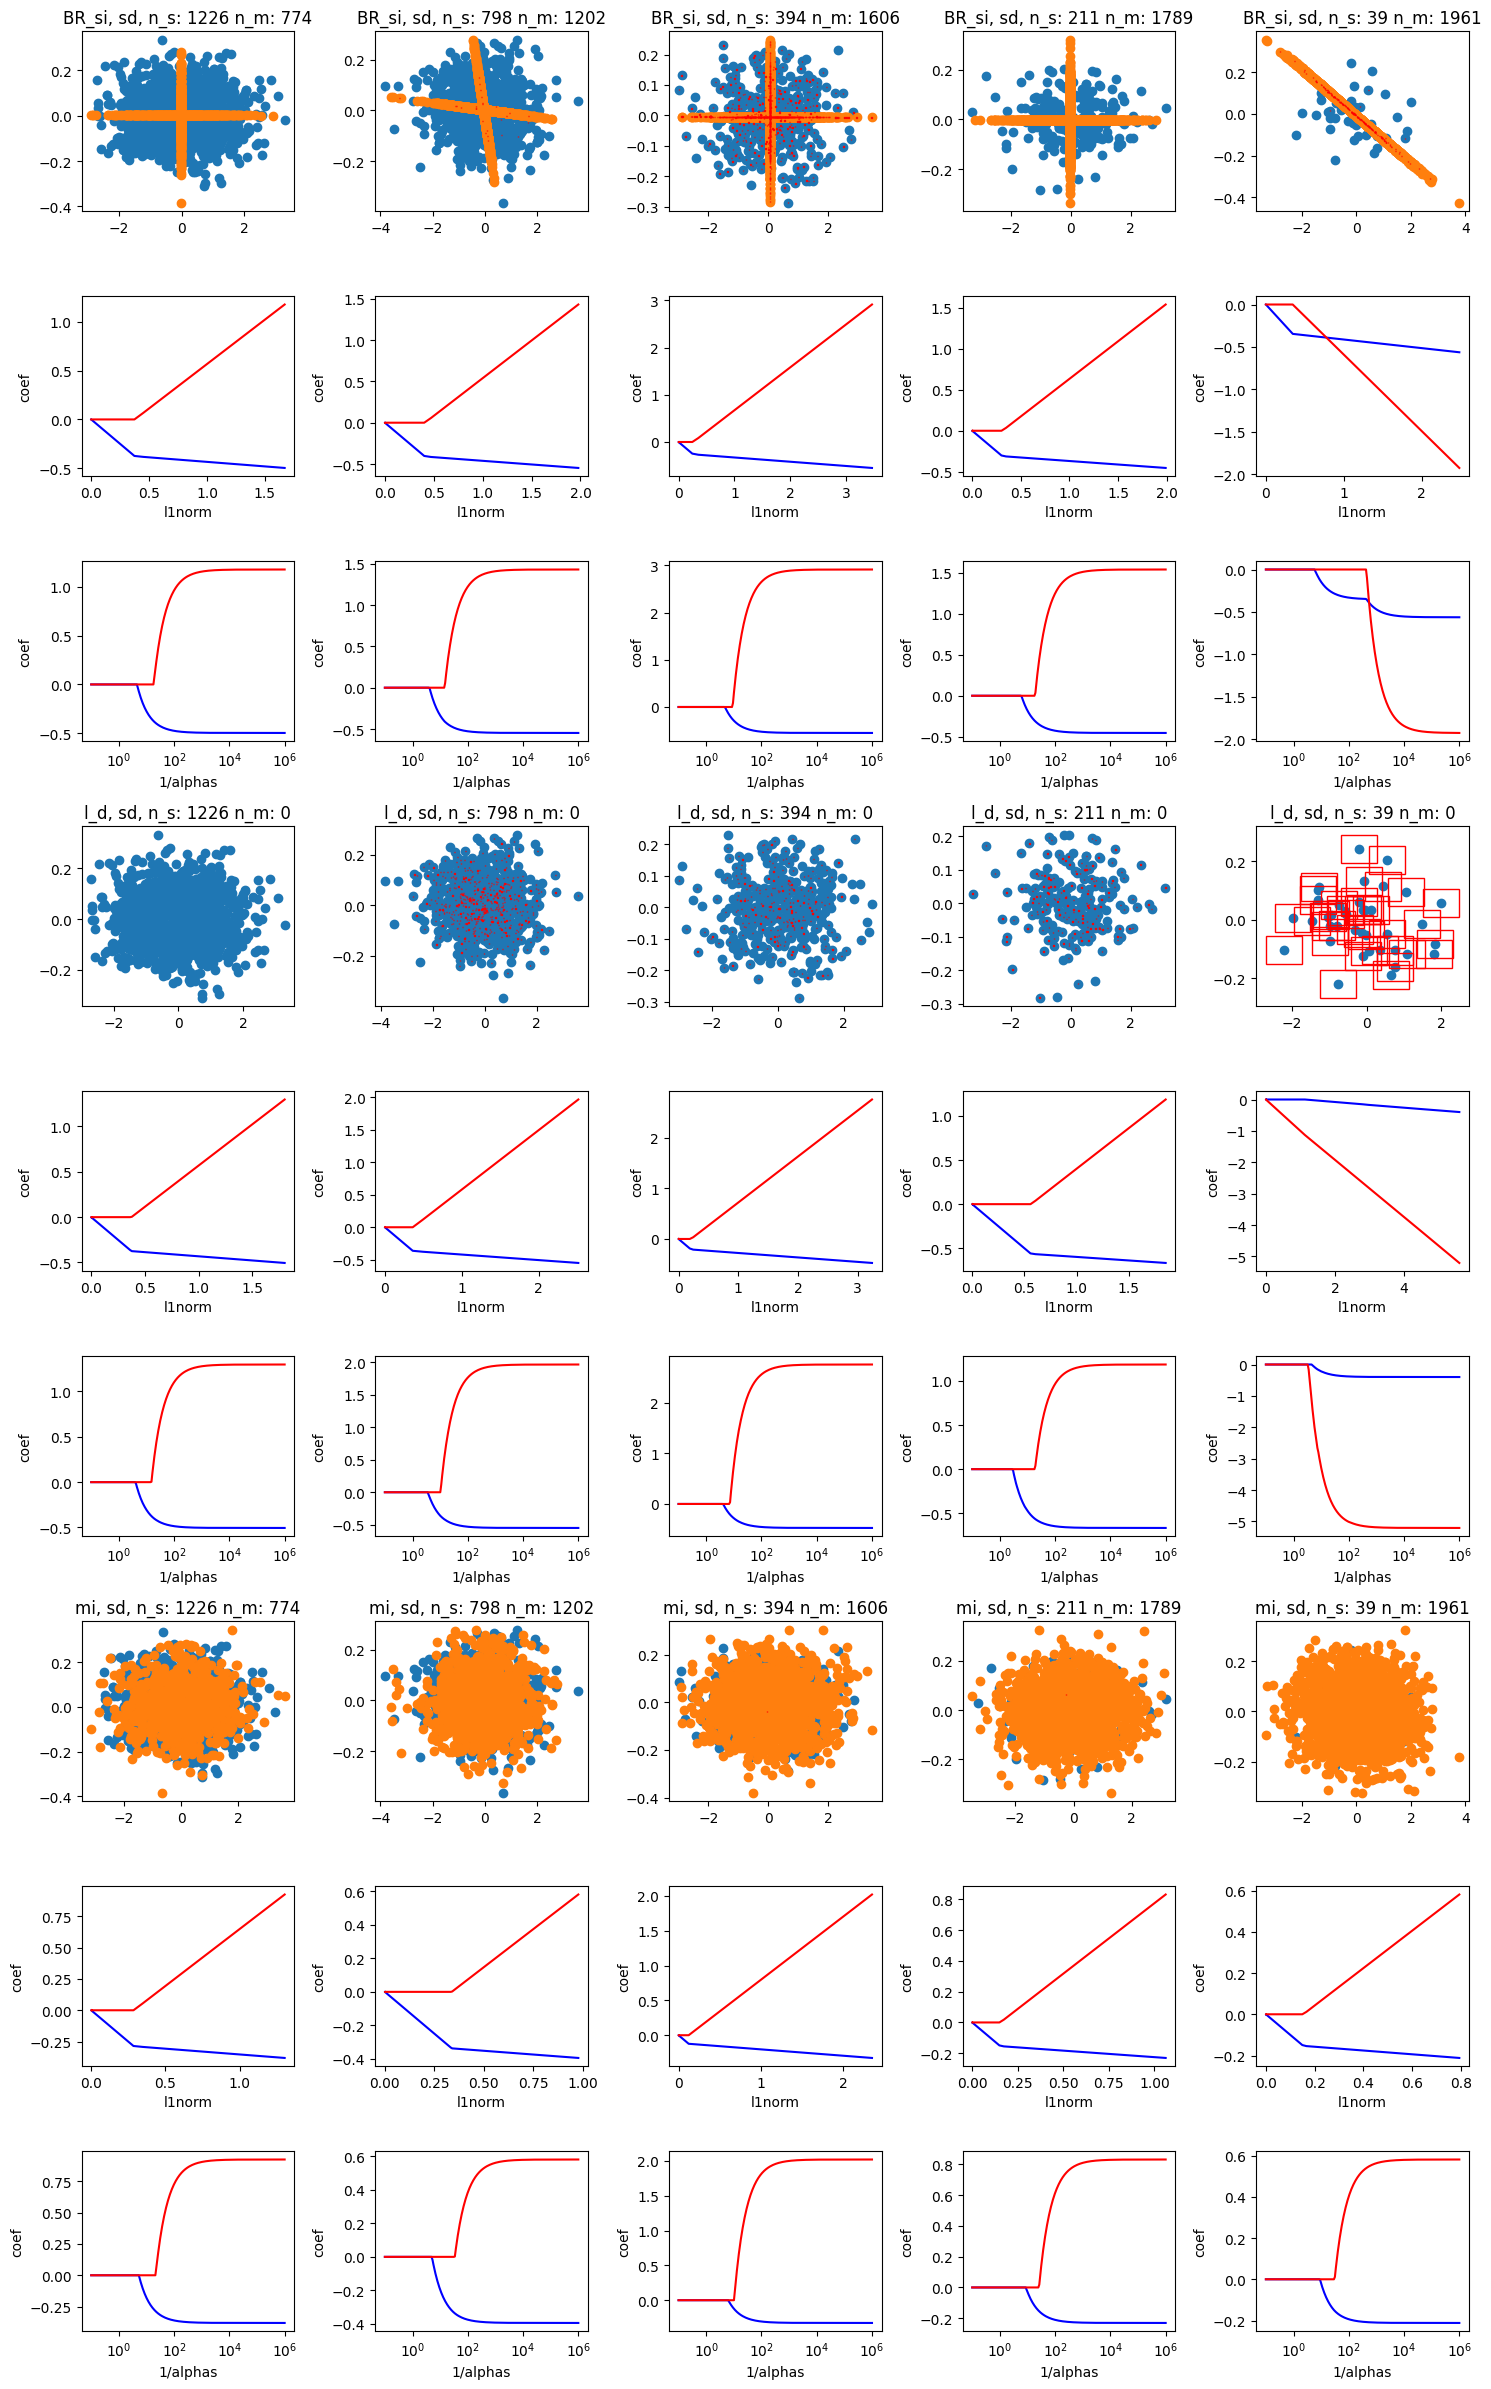

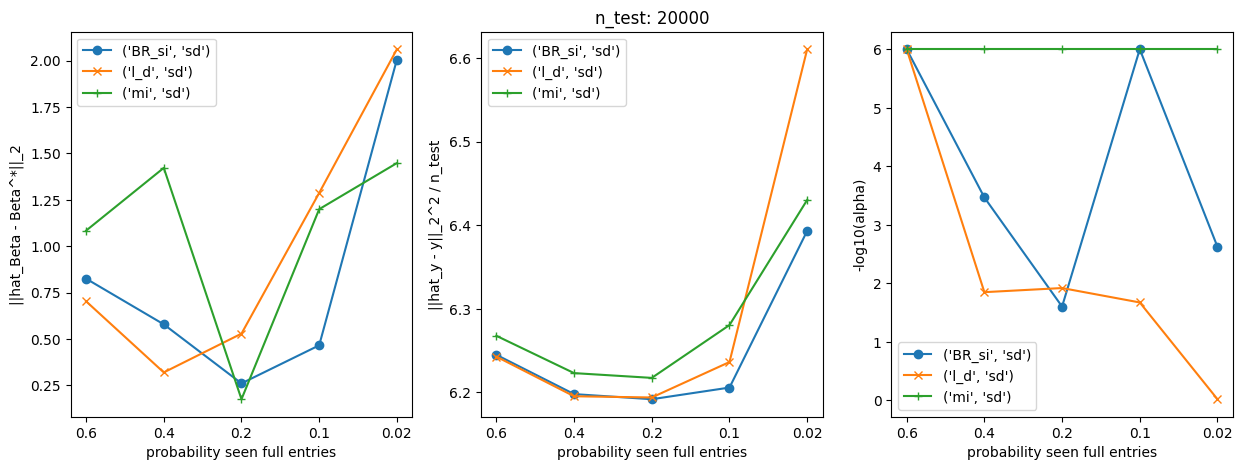

In [119]:
np.random.seed(456)

#info_axis = 'p_seen'  # train or p_seen
#n_train = [1000, 1000, 1000, 1000, 1000]
#p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
#p_seen = make_probabilities(p_seen_both)
#main_vec = n_train if info_axis == 'train' else p_seen_both
#info_x_axis = make_info_axis(main_vec, info_axis)

info_axis = 'p_seen'  # train or p_seen
n_train = [2000, 2000, 2000, 2000, 2000]
p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
error_vec =  [2.5, 2.5, 2.5, 2.5, 2.5]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



In [ ]:
# COMMENT:
# this experiment show that imputing can actually be beneficial, see that BR_si beat list wise deletion when the error starts being mild

change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
n_tot :  22000
n_train :  2000
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9090909090909091
err :  {'type': 'Gaussian_on_y', 'scaling': 0.1}
p_miss :  [0.6, 0.2, 0.2]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'l_d', 'cov_strategy': 'sd'}, {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}]
imp_method :  BR_si
cov_strategy :  sd
imp_method :  l_d
cov_strategy :  sd
imp_method :  mi
cov_strategy :  sd
mi_nbr :  1
----> Starting experiments
---------------------------------------------------------------------------------------------------------------------------> iteration  0
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy

100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.010036838261292124
best coeff  [-0.49718898  1.93373636]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1226 nbr_seen (train):  1226  nbr_miss :  0
---....---....----....--> diag matrix:  [0.99441068 0.10043835]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.009988367513604747
best coeff  [-0.5001997   1.97188935]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1226  nbr_miss :  774
---....---....----....--> diag matrix:  [1.00305729 0.10194773]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 13.95it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.02211728119589139
best coeff  [-0.39825291  1.62805067]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  798  nbr_miss :  1202
---....---....----....--> diag matrix:  [0.84625294 0.0822144 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 14.01it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.01186032441872926
best coeff  [-0.48746027  1.5740719 ]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  798 nbr_seen (train):  798  nbr_miss :  0
---....---....----....--> diag matrix:  [1.03176277 0.09633839]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:06<00:00, 30.03it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  120  best 1/best_alpha  60.10276782070388 , min score  0.009912600732788546
best coeff  [-0.50077369  1.98490049]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  798  nbr_miss :  1202
---....---....----....--> diag matrix:  [0.98817849 0.09728889]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.30it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.03307829127322953
best coeff  [-0.36536091  1.31757278]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  394  nbr_miss :  1606
---....---....----....--> diag matrix:  [0.77488198 0.07669345]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:17<00:00, 11.64it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  125  best 1/best_alpha  40.08806328898464 , min score  0.009933177217470224
best coeff  [-0.49554388  2.04208504]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  394 nbr_seen (train):  394  nbr_miss :  0
---....---....----....--> diag matrix:  [1.02115928 0.09849016]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:06<00:00, 28.99it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  113  best 1/best_alpha  105.9560179277616 , min score  0.009910587659998735
best coeff  [-0.49812772  2.02310025]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  394  nbr_miss :  1606
---....---....----....--> diag matrix:  [1.00724238 0.10044463]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:21<00:00,  9.34it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.055125583493858495
best coeff  [-0.30059686  1.22326179]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  211  nbr_miss :  1789
---....---....----....--> diag matrix:  [0.75180477 0.07021302]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:18<00:00, 11.07it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.01010304513007925
best coeff  [-0.50085301  1.86322146]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  211 nbr_seen (train):  211  nbr_miss :  0
---....---....----....--> diag matrix:  [1.04420399 0.09044008]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 72.89it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  121  best 1/best_alpha  55.42664520663108 , min score  0.009973545582824789
best coeff  [-0.50453584  1.94803084]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  211  nbr_miss :  1789
---....---....----....--> diag matrix:  [1.01385553 0.09374727]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 13.66it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.06870672413160185
best coeff  [-0.27319896  1.12529591]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  39  nbr_miss :  1961
---....---....----....--> diag matrix:  [0.96013284 0.1075206 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.47it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  74  best 1/best_alpha  2494.5081352303164 , min score  0.06012330621286869
best coeff  [-3.95751857e-01 -2.79493973e-06]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  39 nbr_seen (train):  39  nbr_miss :  0
---....---....----....--> diag matrix:  [1.00903652 0.10114417]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 260.76it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  111  best 1/best_alpha  124.5883364295008 , min score  0.010919340342948622
best coeff  [-0.49535332  1.71908294]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  39  nbr_miss :  1961
---....---....----....--> diag matrix:  [1.00915146 0.10182928]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.77it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.07480818773509443
best coeff  [-0.26180984  1.09373797]
x_axis---->  [0.6, 0.4, 0.2, 0.1, 0.02]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.49718898,  1.93373636]), array([-0.48746027,  1.5740719 ]), array([-0.49554388,  2.04208504]), array([-0.50085301,  1.86322146]), array([-3.95751857e-01, -2.79493973e-06])], 'l2_dist_best_coeff_gt': [np.float64(0.06632324022470623), np.float64(0.42611265348407984), np.float64(0.042320301571810465), np.float64(0.13678119593869634), np.float64(2.0027178670738617)], 'best_score': [np.float64(0.010036838261292124), np.float64(0.01186032441872926), np.float64(0.009933177217470224), np.float64(0.01010304513007925), np.float64(0.06012330621286869)], 'best_alpha': [np.float64(6.0), np.float64(6.0), np.float64(1.6030150753768844), np.float64(6.0), np.float64(3.3969849246231156)]}, ('l_d', 'sd'): {'best_coeff': [array([-0.5001997 ,  1.97188935]

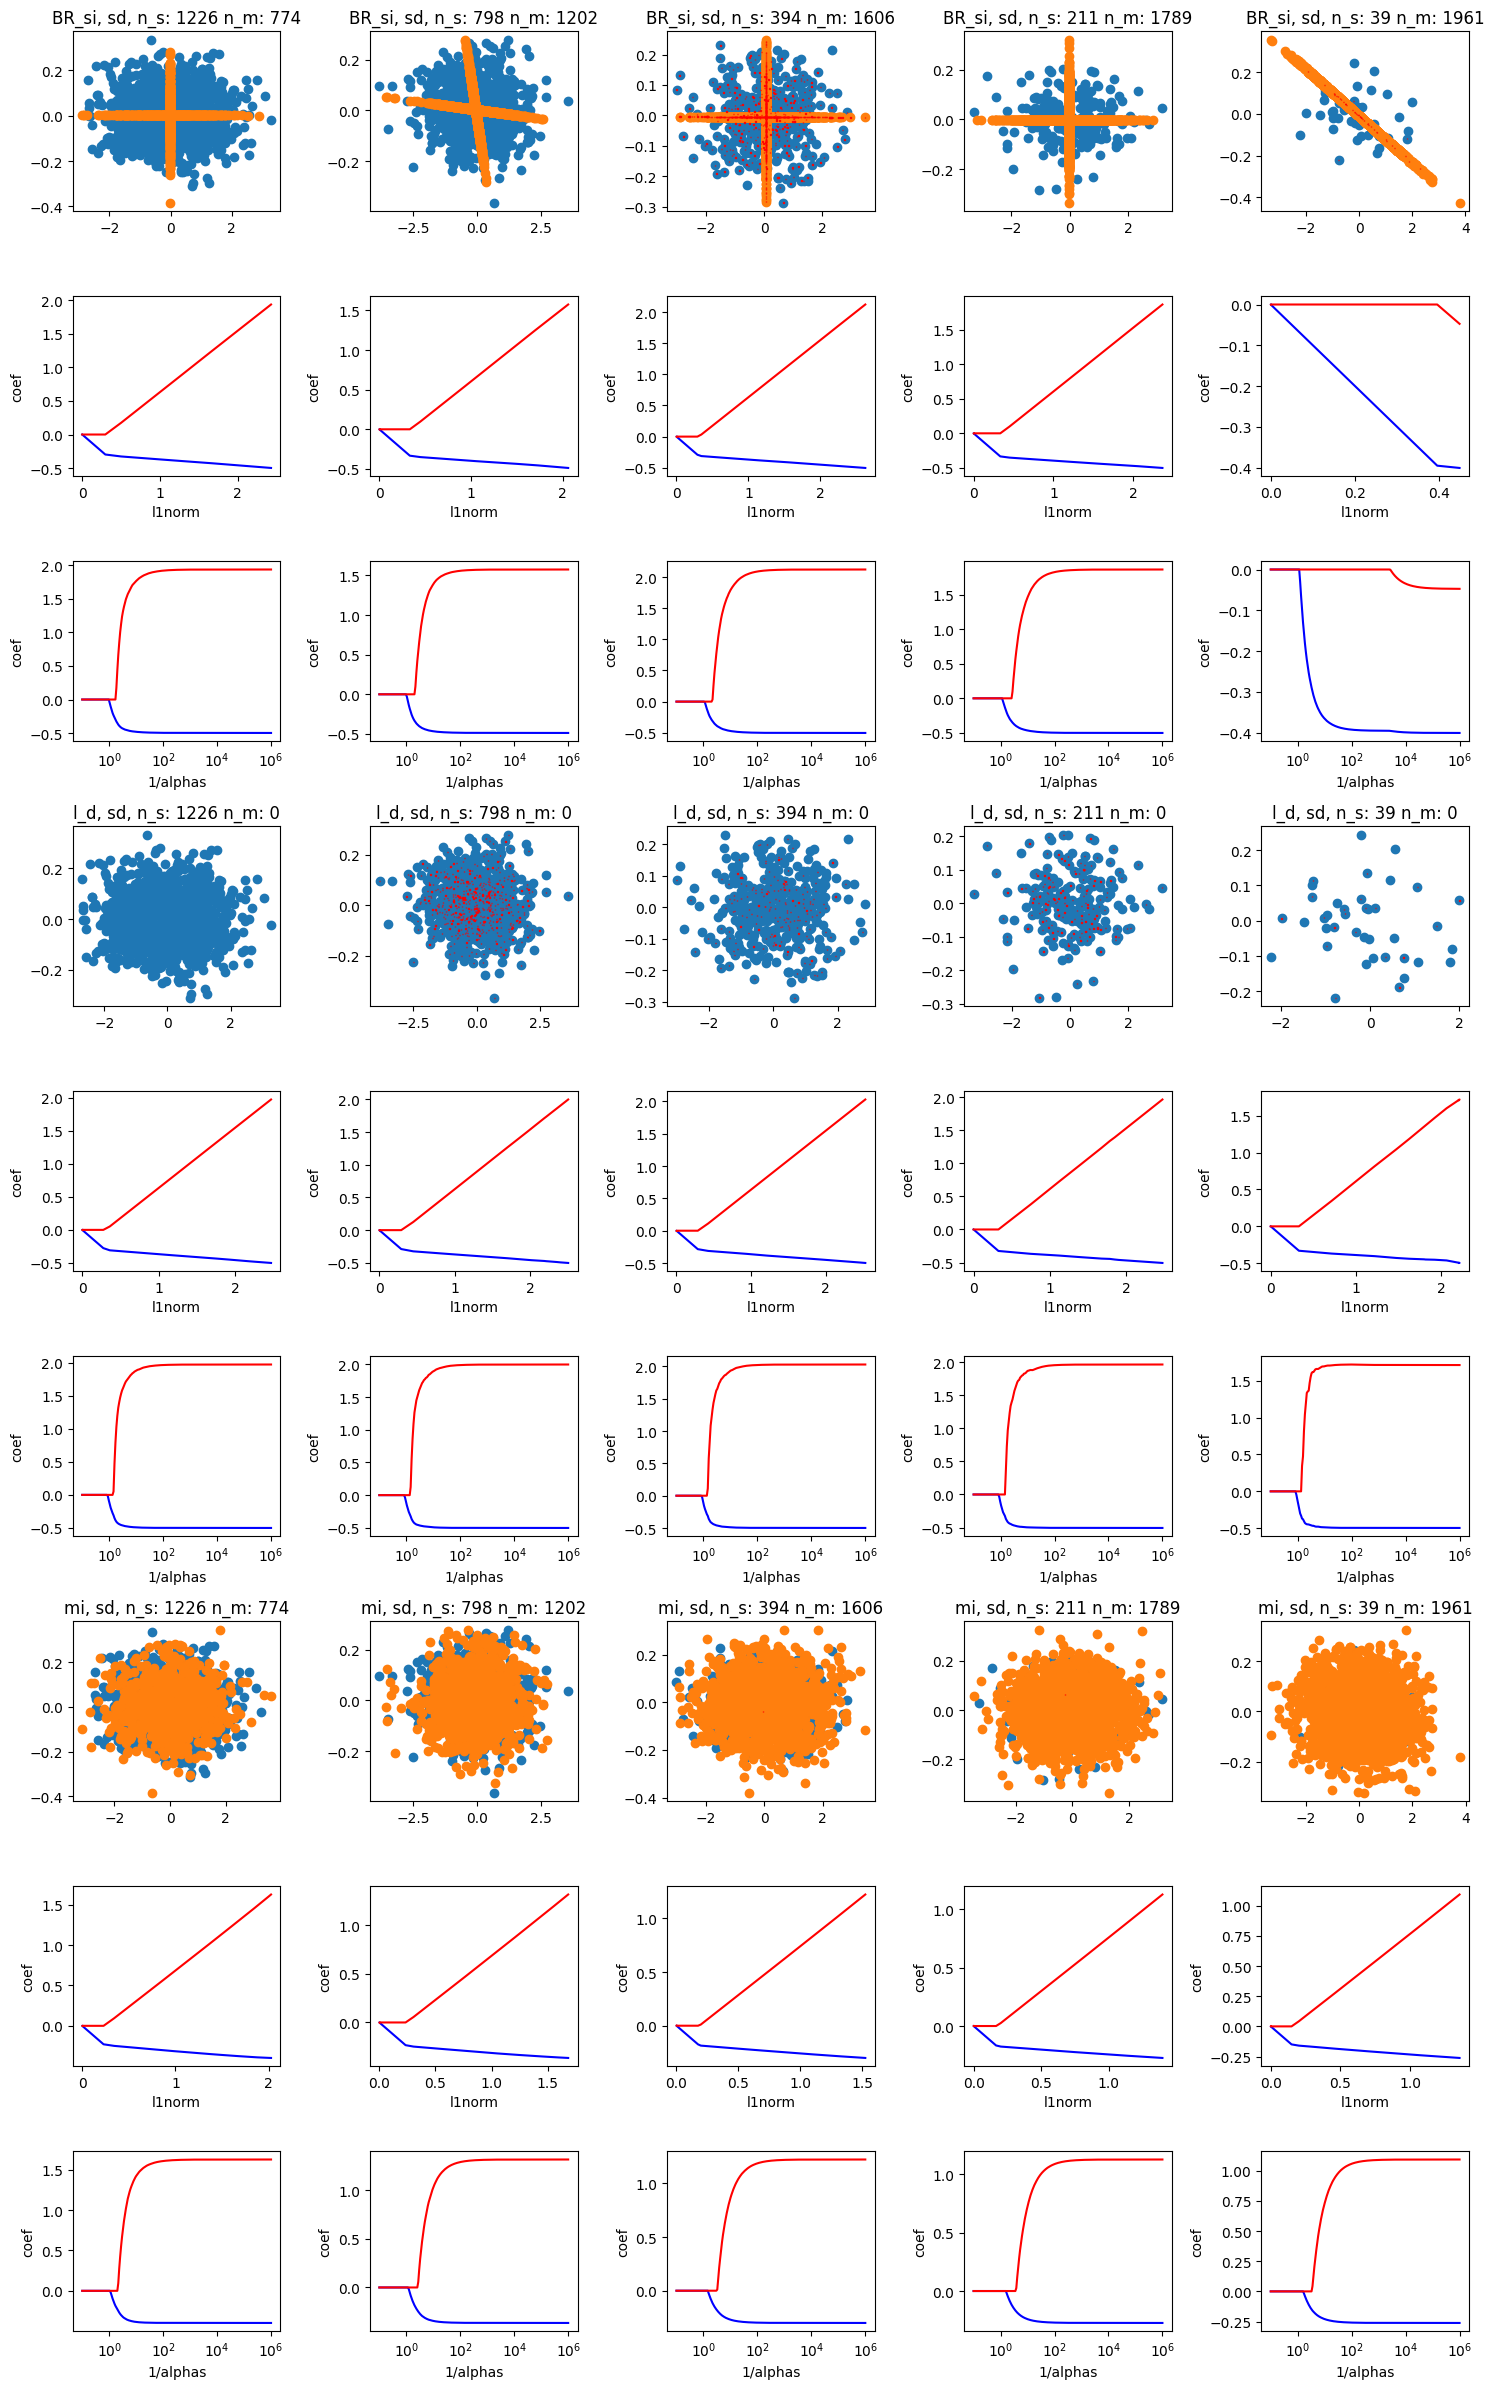

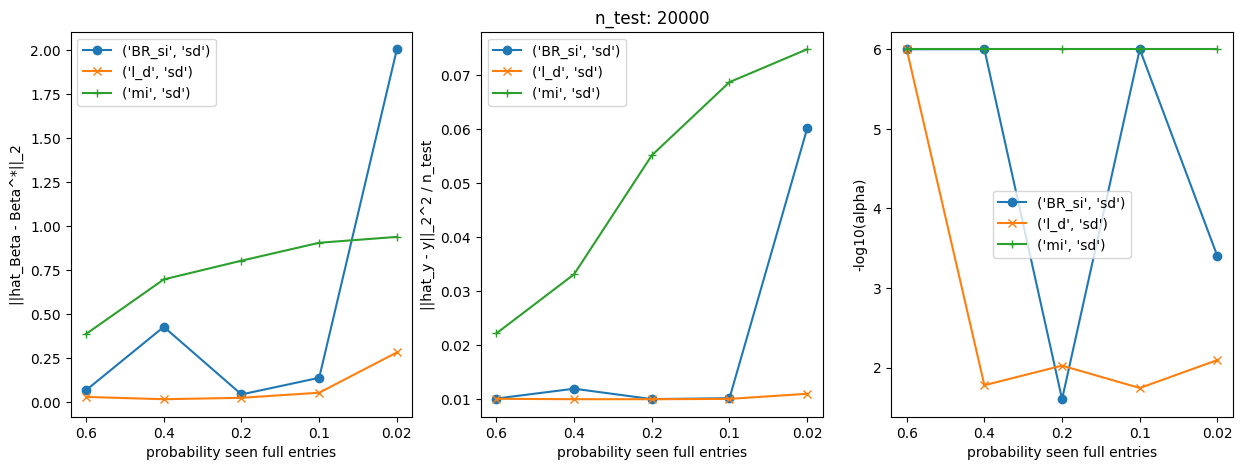

In [120]:
np.random.seed(456)

#info_axis = 'p_seen'  # train or p_seen
#n_train = [2000, 2000, 2000, 2000, 2000]
#p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
#p_seen = make_probabilities(p_seen_both)
#main_vec = n_train if info_axis == 'train' else p_seen_both
#info_x_axis = make_info_axis(main_vec, info_axis)


info_axis = 'p_seen'  # train or p_seen
n_train = [2000, 2000, 2000, 2000, 2000]
p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
error_vec =  [0.1, 0.1, 0.1, 0.1, 0.1]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]

print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



In [ ]:
# COMMENTS

# in this experiment we have low error_on_y with increasing percentage of missing components. We can see as without noise listwise deletion is the best model
# BR_si can keep up, if the imputation method is good. mi cannot compete, probably for the reason explained before that drwas from
# the posterior does not conserve the relation <x, beta> close to y

change nbr_experiments to match the size of n_train
data :  {'data': 'moons'}
n_tot :  22000
n_train :  2000
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9090909090909091
err :  {'type': 'Gaussian_on_y', 'scaling': 0.1}
p_miss :  [0.6, 0.2, 0.2]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'l_d', 'cov_strategy': 'sd'}, {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}]
imp_method :  BR_si
cov_strategy :  sd
imp_method :  l_d
cov_strategy :  sd
imp_method :  mi
cov_strategy :  sd
mi_nbr :  1
----> Starting experiments
---------------------------------------------------------------------------------------------------------------------------> iteration  0
{'data': 'moons'}
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1187  nbr_miss :  813
---....---....----....--> diag matrix:  [0.81004583 0.46352512]
w

100%|██████████| 200/200 [00:14<00:00, 13.53it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.011440340900024045
best coeff  [-0.47613161  1.95547067]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1187 nbr_seen (train):  1187  nbr_miss :  0
---....---....----....--> diag matrix:  [0.87427574 0.49512902]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.45it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.010169410253286836
best coeff  [-0.49633065  1.98582291]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1187  nbr_miss :  813
---....---....----....--> diag matrix:  [0.88630025 0.4999641 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  131  best 1/best_alpha  24.65811075822604 , min score  0.038972502416867026
best coeff  [-0.44520892  1.7261661 ]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'moons'}
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  790  nbr_miss :  1210
---....---....----....--> diag matrix:  [0.80109694 0.45723203]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:18<00:00, 10.89it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.02258147058242893
best coeff  [-0.41707402  1.88143785]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  790 nbr_seen (train):  790  nbr_miss :  0
---....---....----....--> diag matrix:  [0.87628145 0.49135813]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 13.66it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  124  best 1/best_alpha  43.470131581250264 , min score  0.00989200032647523
best coeff  [-0.49893497  2.00063608]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  790  nbr_miss :  1210
---....---....----....--> diag matrix:  [0.87564433 0.49228021]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 13.96it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.053049023944313205
best coeff  [-0.43634345  1.65965452]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'moons'}
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  414  nbr_miss :  1586
---....---....----....--> diag matrix:  [0.81833633 0.48873741]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 13.91it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.06205159195365369
best coeff  [-0.34396747  1.73988465]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  414 nbr_seen (train):  414  nbr_miss :  0
---....---....----....--> diag matrix:  [0.86437665 0.50770726]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:03<00:00, 58.52it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.010039261125397516
best coeff  [-0.49728408  1.99687665]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  414  nbr_miss :  1586
---....---....----....--> diag matrix:  [0.87793503 0.51197014]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 14.18it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.10901964180387816
best coeff  [-0.4124373   1.48229372]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'moons'}
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  206  nbr_miss :  1794
---....---....----....--> diag matrix:  [0.85633145 0.48124385]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.38it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.09857316180404489
best coeff  [-0.26953609  1.70962599]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  206 nbr_seen (train):  206  nbr_miss :  0
---....---....----....--> diag matrix:  [0.87665478 0.49744911]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 86.90it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  132  best 1/best_alpha  22.739657523579275 , min score  0.009926496697493898
best coeff  [-0.50262737  1.99254506]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  206  nbr_miss :  1794
---....---....----....--> diag matrix:  [0.87818264 0.50907175]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:14<00:00, 14.24it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.15902899375210128
best coeff  [-0.4024214   1.35616107]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'moons'}
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  44  nbr_miss :  1956
---....---....----....--> diag matrix:  [0.97063612 0.45649239]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.36it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.083165262139723
best coeff  [-0.32144414  1.67679766]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  44 nbr_seen (train):  44  nbr_miss :  0
---....---....----....--> diag matrix:  [0.93479463 0.48737193]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 258.20it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  161  best 1/best_alpha  2.171117945694505 , min score  0.012346668823791367
best coeff  [-0.50687227  1.91120804]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  44  nbr_miss :  1956
---....---....----....--> diag matrix:  [0.87286029 0.50468456]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.38it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  0.14467193721343113
best coeff  [-0.4191386   1.38083403]
x_axis---->  [0.6, 0.4, 0.2, 0.1, 0.02]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.47613161,  1.95547067]), array([-0.41707402,  1.88143785]), array([-0.34396747,  1.73988465]), array([-0.26953609,  1.70962599]), array([-0.32144414,  1.67679766])], 'l2_dist_best_coeff_gt': [np.float64(0.050522879048770106), np.float64(0.14468483861853723), np.float64(0.30332515066029114), np.float64(0.3707164412567508), np.float64(0.36924510935048044)], 'best_score': [np.float64(0.011440340900024045), np.float64(0.02258147058242893), np.float64(0.06205159195365369), np.float64(0.09857316180404489), np.float64(0.083165262139723)], 'best_alpha': [np.float64(6.0), np.float64(6.0), np.float64(6.0), np.float64(6.0), np.float64(6.0)]}, ('l_d', 'sd'): {'best_coeff': [array([-0.49633065,  1.98582291]), array([-0.49893497,  2.00063608]), arr

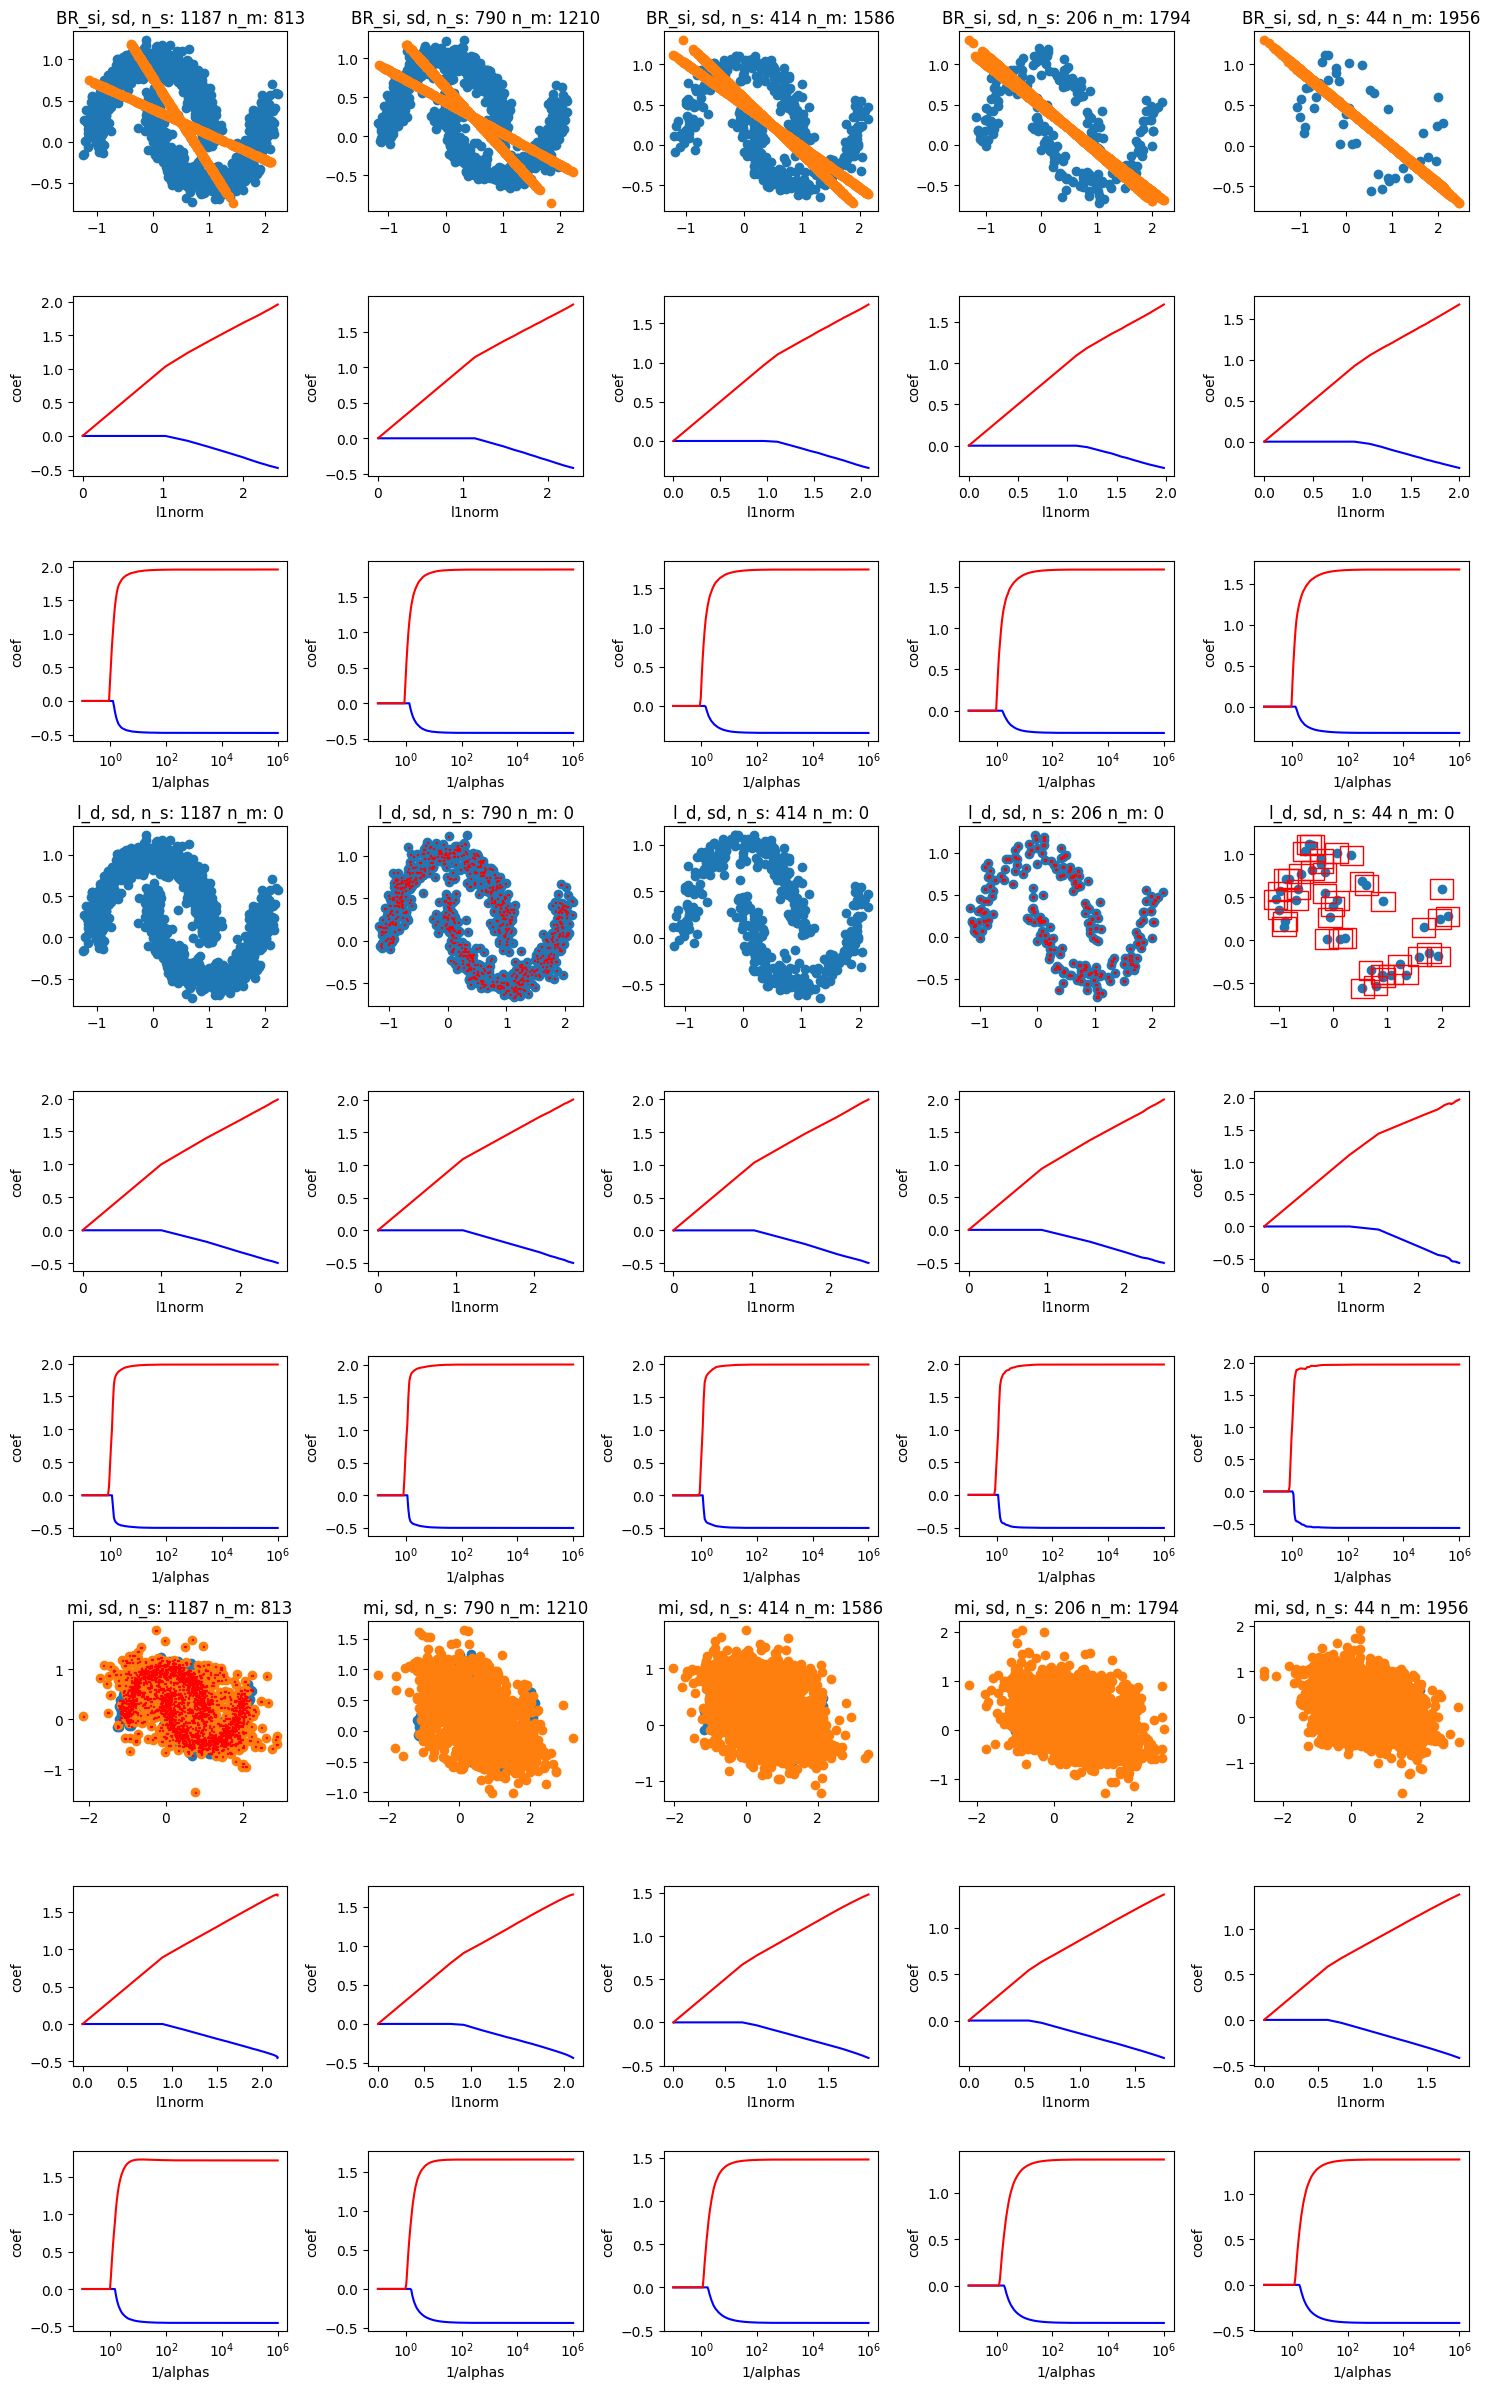

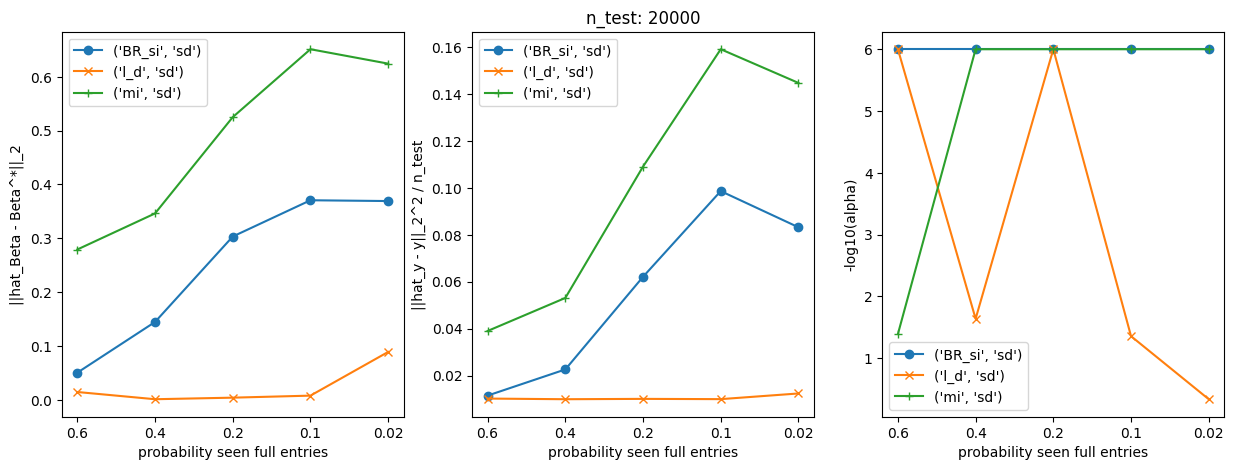

In [121]:
np.random.seed(456)

#info_axis = 'p_seen'  # train or p_seen
#n_train = [2000, 2000, 2000, 2000, 2000]
#p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
#p_seen = make_probabilities(p_seen_both)
#main_vec = n_train if info_axis == 'train' else p_seen_both
#info_x_axis = make_info_axis(main_vec, info_axis)


info_axis = 'p_seen'  # train or p_seen
n_train = [2000, 2000, 2000, 2000, 2000]
p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
error_vec =  [0.1, 0.1, 0.1, 0.1, 0.1]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'moons'},# 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]

print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



In [ ]:
# if the data have low noise and present nonlinearities, the single imputation method cannot keep  up with listwise deletion, if the percentage of missing decrease

In [ ]:
np.random.seed(456)

#info_axis = 'p_seen'  # train or p_seen
#n_train = [2000, 2000, 2000, 2000, 2000]
#p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
#p_seen = make_probabilities(p_seen_both)
#main_vec = n_train if info_axis == 'train' else p_seen_both
#info_x_axis = make_info_axis(main_vec, info_axis)


info_axis = 'p_seen'  # train or p_seen
n_train = [2000, 2000, 2000, 2000, 2000]
p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
error_vec =  [5, 5, 5, 5, 5]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'moons'},# 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'l_d', 'cov_strategy': 'sd'},
                        {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1},
                        ]

print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



change nbr_experiments to match the size of n_train
data :  [{'data': 'moons'}, {'data': 'moons'}, {'data': 'moons'}, {'data': 'moons'}, {'data': 'moons'}]
n_tot :  [20300, 20600, 20900, 21200, 21500]
n_train :  [300, 600, 900, 1200, 1500]
n_test :  [20000, 20000, 20000, 20000, 20000]
dim :  [2, 2, 2, 2, 2]
beta_gt :  [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
perc_test :  [0.9852216748768473, 0.970873786407767, 0.9569377990430622, 0.9433962264150944, 0.9302325581395349]
err :  [{'type': 'Gaussian_on_y', 'scaling': 4}, {'type': 'Gaussian_on_y', 'scaling': 4}, {'type': 'Gaussian_on_y', 'scaling': 4}, {'type': 'Gaussian_on_y', 'scaling': 4}, {'type': 'Gaussian_on_y', 'scaling': 4}]
p_miss :  [[0.1, 0.45, 0.45], [0.1, 0.45, 0.45], [0.1, 0.45, 0.45], [0.1, 0.45, 0.45], [0.1, 0.45, 0.45]]
[{'imp_method': 'BR_si', 'cov_strategy': 'eye'}, {'imp_method': 'l_d', 'cov_strategy': 'eye'}, {'imp_method': 'mi', 'cov_strategy': 'eye', 'mi

100%|██████████| 200/200 [00:02<00:00, 80.92it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.06528179201178
best coeff  [-0.35348434  1.20972757]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  30 nbr_seen (train):  30  nbr_miss :  0
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 265.70it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.61999769655822
best coeff  [-0.17599176  0.60027636]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'eye', 'mi_nbr': 1}
-------> size test:  20000  , size train:  300 nbr_seen (train):  30  nbr_miss :  270
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 68.35it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.094307712281854
best coeff  [-0.47152828  1.08424982]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'moons'}
(20600, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  600 nbr_seen (train):  74  nbr_miss :  526
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:04<00:00, 42.03it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  15.992573311964989
best coeff  [-0.25608043  1.20870433]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  74 nbr_seen (train):  74  nbr_miss :  0
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 139.57it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.014097534392917
best coeff  [-0.60659105  0.98051994]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'eye', 'mi_nbr': 1}
-------> size test:  20000  , size train:  600 nbr_seen (train):  74  nbr_miss :  526
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:04<00:00, 41.64it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.091333081142153
best coeff  [-0.40848561  0.89359932]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'moons'}
(20900, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  900 nbr_seen (train):  104  nbr_miss :  796
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 22.84it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  15.947460012932096
best coeff  [-0.35411911  1.8965362 ]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  104 nbr_seen (train):  104  nbr_miss :  0
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 162.04it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  129  best 1/best_alpha  28.99422853882875 , min score  15.998611602190385
best coeff  [-0.28981562  2.4521393 ]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'eye', 'mi_nbr': 1}
-------> size test:  20000  , size train:  900 nbr_seen (train):  104  nbr_miss :  796
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 22.91it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  15.960437317232515
best coeff  [-0.42538188  1.69519975]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'moons'}
(21200, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  103  nbr_miss :  1097
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.69it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.318444476041595
best coeff  [-0.20776363  1.40012464]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  103 nbr_seen (train):  103  nbr_miss :  0
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 145.25it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.372204492356705
best coeff  [-0.67989438  1.03265011]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'eye', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  103  nbr_miss :  1097
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.394638085305736
best coeff  [-0.247493    1.18521891]
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'moons'}
(21500, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1500 nbr_seen (train):  139  nbr_miss :  1361
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:19<00:00, 10.47it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.233259895503313
best coeff  [-0.38874336  1.52453514]
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  139 nbr_seen (train):  139  nbr_miss :  0
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 122.60it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  126  best 1/best_alpha  36.96912707195025 , min score  16.144564971186348
best coeff  [-0.57364732  1.95775646]
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'eye', 'mi_nbr': 1}
-------> size test:  20000  , size train:  1500 nbr_seen (train):  139  nbr_miss :  1361
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 19.37it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  16.24456697325646
best coeff  [-0.54043902  1.4374147 ]
x_axis---->  [300, 600, 900, 1200, 1500]
res
  {('BR_si', 'eye'): {'best_coeff': [array([-0.35348434,  1.20972757]), array([-0.25608043,  1.20870433]), array([-0.35411911,  1.8965362 ]), array([-0.20776363,  1.40012464]), array([-0.38874336,  1.52453514])], 'l2_dist_best_coeff_gt': [np.float64(0.8037396042887982), np.float64(0.8280371887144629), np.float64(0.1788462745161573), np.float64(0.6672724666379171), np.float64(0.4883081713407455)], 'best_score': [np.float64(16.06528179201178), np.float64(15.992573311964989), np.float64(15.947460012932096), np.float64(16.318444476041595), np.float64(16.233259895503313)], 'best_alpha': [np.float64(6.0), np.float64(6.0), np.float64(6.0), np.float64(6.0), np.float64(6.0)]}, ('l_d', 'eye'): {'best_coeff': [array([-0.17599176,  0.60027636]), array([-0.60659105,  0.98051994]), array([-0.28

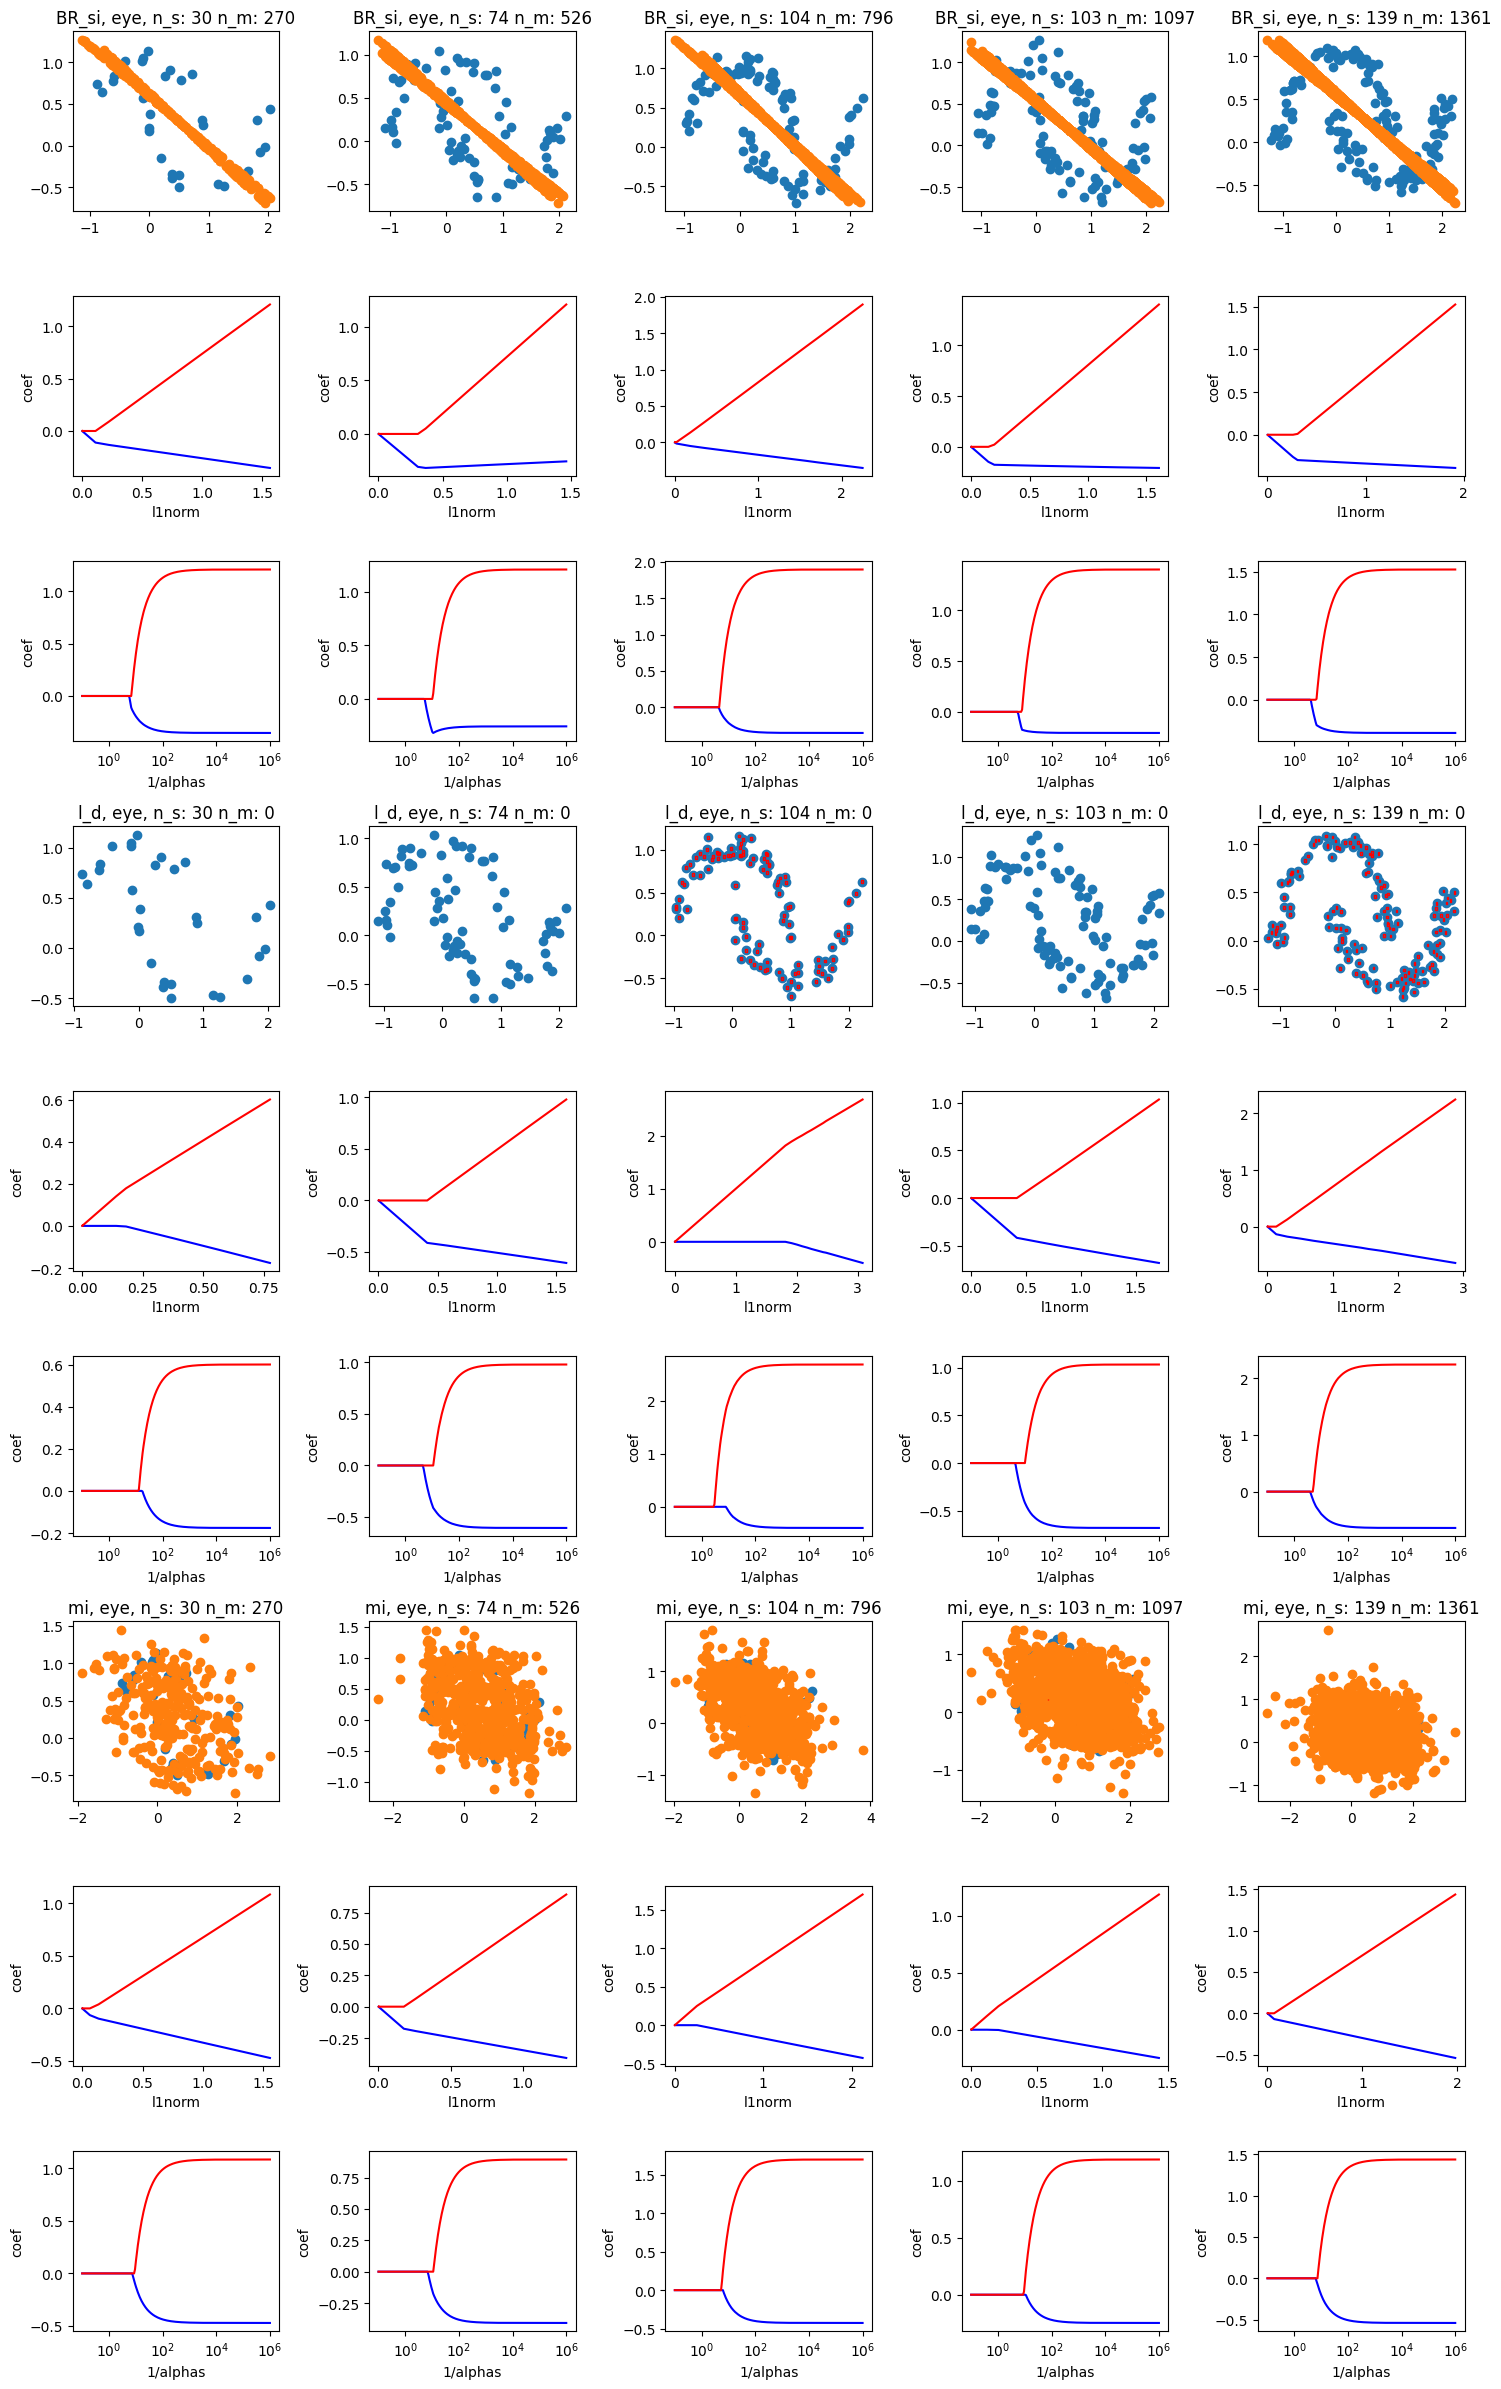

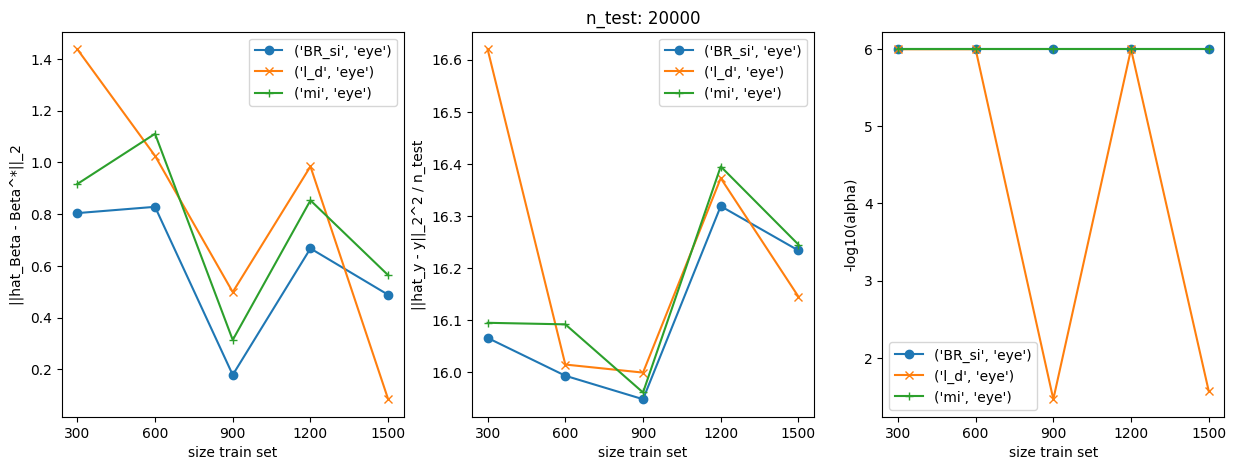

In [122]:
np.random.seed(456)

info_axis = 'train'  # train or p_seen
n_train = [300, 600, 900, 1200, 1500]
p_seen_both = [0.1, 0.1, 0.1, 0.1, 0.1]
error_vec =  [4, 4, 4, 4, 4]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'moons'},# 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    #data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye'},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye'},
                        {'imp_method': 'mi', 'cov_strategy': 'eye', 'mi_nbr':1},
                        ]


#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)


In [ ]:
# COMMENT:
# adding error to y, list wise deletion can be beaten.

change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}]
n_tot :  [22000, 22000, 22000, 22000, 22000]
n_train :  [2000, 2000, 2000, 2000, 2000]
n_test :  [20000, 20000, 20000, 20000, 20000]
dim :  [2, 2, 2, 2, 2]
beta_gt :  [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
perc_test :  [0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091]
err :  [{'type': 'Gaussian_on_y', 'scaling': 3}, {'type': 'Gaussian_on_y', 'scalin

100%|██████████| 200/200 [00:13<00:00, 14.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  8.992484202293824
best coeff  [-0.49582693  1.0173187 ]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1226  nbr_miss :  774
---....---....----....--> diag matrix:  [ 1.11948067 10.91152382]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  8.992546470965184
best coeff  [-0.49583118  1.01426505]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  1226  nbr_miss :  774
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.52it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  8.992489433339543
best coeff  [-0.49582703  1.01706232]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  814  nbr_miss :  1186
---....---....----....--> diag matrix:  [0.8521595  0.08586194]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.55it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.13661138956218
best coeff  [-0.48001756  1.56706685]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  814  nbr_miss :  1186
---....---....----....--> diag matrix:  [ 1.17348923 11.64660359]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.35it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.136645410960755
best coeff  [-0.48001578  1.56331543]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  814  nbr_miss :  1186
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.81it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.136614127306931
best coeff  [-0.48001702  1.56677021]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  397  nbr_miss :  1603
---....---....----....--> diag matrix:  [0.90211666 0.09004342]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:22<00:00,  8.76it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  118  best 1/best_alpha  70.67181273927491 , min score  9.114800459230581
best coeff  [-3.67909702e-01 -1.91820910e-07]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  397  nbr_miss :  1603
---....---....----....--> diag matrix:  [ 1.10850408 11.10575291]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:21<00:00,  9.18it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  65  best 1/best_alpha  5170.920242896761 , min score  9.10555028086785
best coeff  [-4.05851147e-01 -2.64657332e-07]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  397  nbr_miss :  1603
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  94  best 1/best_alpha  493.7047852839003 , min score  9.106707785108911
best coeff  [-4.00382016e-01 -3.88365755e-07]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  233  nbr_miss :  1767
---....---....----....--> diag matrix:  [0.74671928 0.07353195]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.26it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  110  best 1/best_alpha  135.09935211980266 , min score  9.008916512691254
best coeff  [-5.07834707e-01 -1.48823733e-05]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  233  nbr_miss :  1767
---....---....----....--> diag matrix:  [ 1.33919135 13.59953047]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  46  best 1/best_alpha  24094.03560239527 , min score  9.006875346712054
best coeff  [-5.31061677e-01 -9.45658631e-07]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  233  nbr_miss :  1767
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.37it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  78  best 1/best_alpha  1804.186409392072 , min score  9.00701751639273
best coeff  [-5.28946561e-01 -1.22698050e-05]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(22000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  31  nbr_miss :  1969
---....---....----....--> diag matrix:  [0.93339003 0.10257204]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.22it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  100  best 1/best_alpha  303.67711180354576 , min score  9.210264160422545
best coeff  [-3.50792465e-01 -4.05332427e-07]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  31  nbr_miss :  1969
---....---....----....--> diag matrix:  [1.0713635  9.74924587]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 14.87it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  52  best 1/best_alpha  14820.2070579886 , min score  9.207546812055009
best coeff  [-3.58848513e-01 -1.11429440e-07]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  2000 nbr_seen (train):  31  nbr_miss :  1969
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:13<00:00, 15.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  79  best 1/best_alpha  1663.816886076129 , min score  9.208016045339193
best coeff  [-3.57429382e-01 -2.83822880e-07]
x_axis---->  [0.6, 0.4, 0.2, 0.1, 0.02]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.49582693,  1.0173187 ]), array([-0.48001756,  1.56706685]), array([-3.67909702e-01, -1.91820910e-07]), array([-5.07834707e-01, -1.48823733e-05]), array([-3.50792465e-01, -4.05332427e-07])], 'l2_dist_best_coeff_gt': [np.float64(0.982690161543077), np.float64(0.4333940577044455), np.float64(2.0043574067560845), np.float64(2.0000302278582573), np.float64(2.0055584034858707)], 'best_score': [np.float64(8.992484202293824), np.float64(9.13661138956218), np.float64(9.114800459230581), np.float64(9.008916512691254), np.float64(9.210264160422545)], 'best_alpha': [np.float64(6.0), np.float64(6.0), np.float64(1.849246231155779), np.float64(2.130653266331658), np.float64(2.4824120603015074)]}, ('BR_si', 'inv_sd'): {'best_coeff': [a

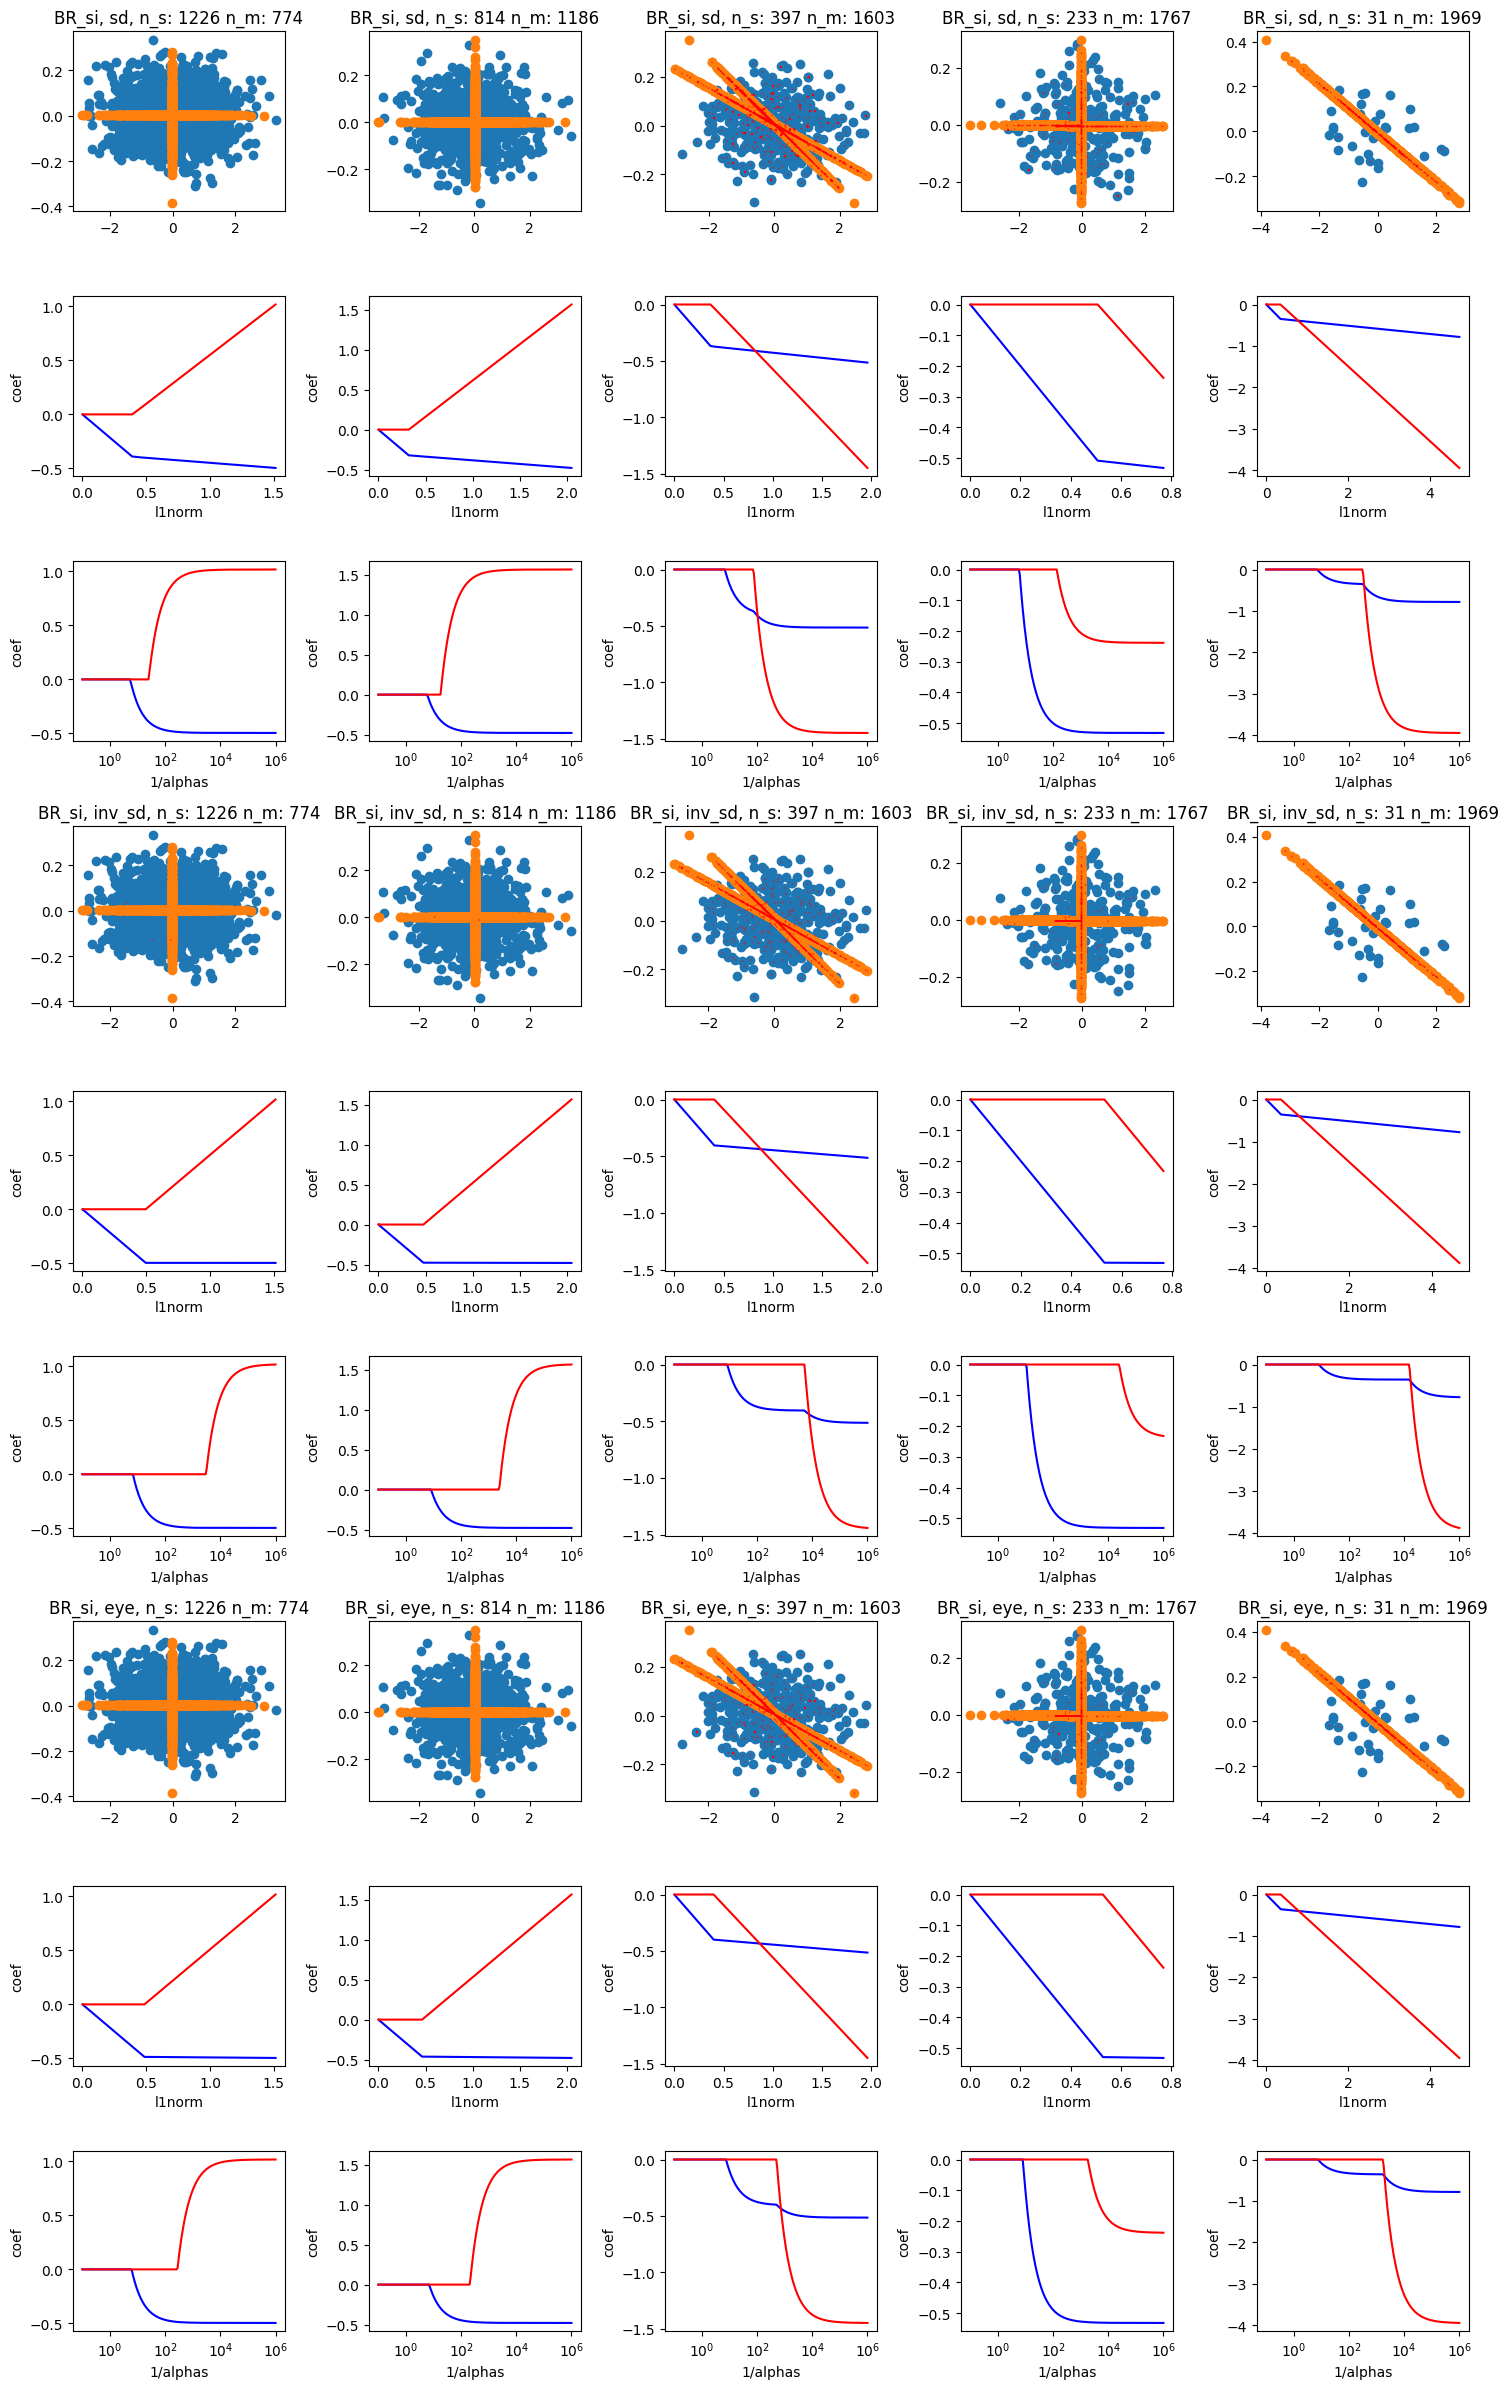

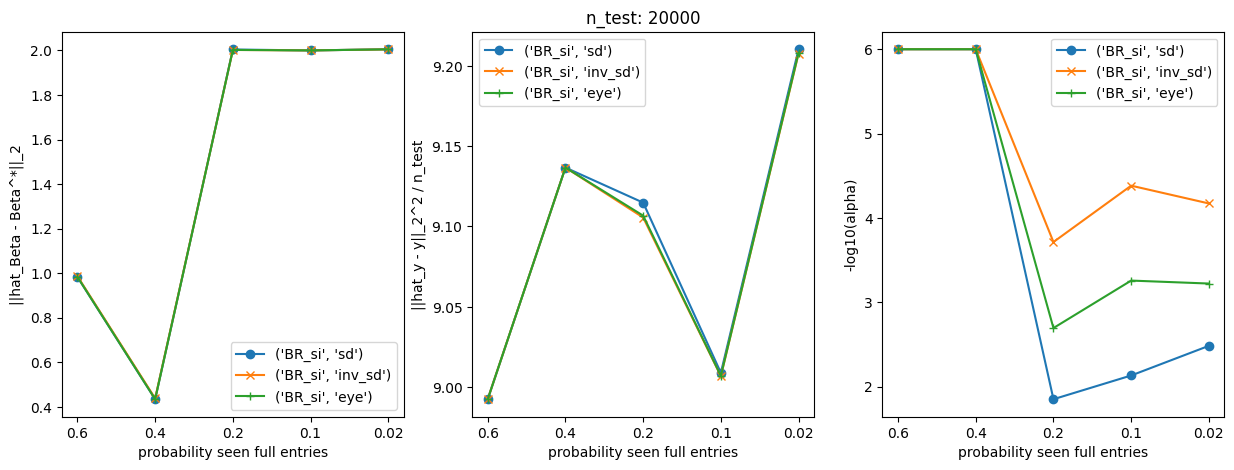

change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}]
n_tot :  [20300, 20600, 20900, 21200, 21500]
n_train :  [300, 600, 900, 1200, 1500]
n_test :  [20000, 20000, 20000, 20000, 20000]
dim :  [2, 2, 2, 2, 2]
beta_gt :  [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
perc_test :  [0.9852216748768473, 0.970873786407767, 0.9569377990430622, 0.9433962264150944, 0.9302325581395349]
err :  [{'type': 'Gaussian_on_y', 'scaling': 3}, {'type': 'Gaussian_on_y', 'scaling': 

100%|██████████| 200/200 [00:02<00:00, 67.38it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.057946294139924
best coeff  [-0.27530922  4.01789776]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  300 nbr_seen (train):  25  nbr_miss :  275
---....---....----....--> diag matrix:  [ 1.30587077 14.03755703]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 79.78it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  69  best 1/best_alpha  3739.9373024787974 , min score  9.030197512212425
best coeff  [-0.27023426  2.32784139]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  300 nbr_seen (train):  25  nbr_miss :  275
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:03<00:00, 58.35it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  100  best 1/best_alpha  303.67711180354576 , min score  9.036110143330333
best coeff  [-0.25933185  2.53317372]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  300 nbr_seen (train):  25  nbr_miss :  275
---....---....----....--> diag matrix:  [0.76577256 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 82.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  99  best 1/best_alpha  329.29712550971516 , min score  9.057674620912538
best coeff  [-0.26607745  3.87906188]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20600, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  600 nbr_seen (train):  54  nbr_miss :  546
---....---....----....--> diag matrix:  [0.72565455 0.07414797]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:04<00:00, 42.75it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.054261250834552
best coeff  [-0.1236953   2.24700474]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  600 nbr_seen (train):  54  nbr_miss :  546
---....---....----....--> diag matrix:  [ 1.37806618 13.48654537]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:05<00:00, 37.90it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  34  best 1/best_alpha  63682.499447185866 , min score  9.054152925843686
best coeff  [-0.1235191   2.14733165]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  600 nbr_seen (train):  54  nbr_miss :  546
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:05<00:00, 39.91it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.054261043942514
best coeff  [-0.12369364  2.24656884]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  600 nbr_seen (train):  54  nbr_miss :  546
---....---....----....--> diag matrix:  [0.72565455 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:04<00:00, 42.34it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.054261211037915
best coeff  [-0.12369529  2.24699258]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(20900, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  900 nbr_seen (train):  107  nbr_miss :  793
---....---....----....--> diag matrix:  [0.99354816 0.09609383]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.96it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.10383727148589
best coeff  [-0.26487406  0.39513524]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  900 nbr_seen (train):  107  nbr_miss :  793
---....---....----....--> diag matrix:  [ 1.00649374 10.40649501]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:11<00:00, 17.45it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  39  best 1/best_alpha  42475.71552536894 , min score  9.102275051417397
best coeff  [-0.29008915  0.10322998]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  900 nbr_seen (train):  107  nbr_miss :  793
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.61it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  68  best 1/best_alpha  4055.460735840828 , min score  9.102498053016767
best coeff  [-0.28771858  0.12448378]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  900 nbr_seen (train):  107  nbr_miss :  793
---....---....----....--> diag matrix:  [0.99354816 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 27.86it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.103837222485442
best coeff  [-0.26487446  0.39513055]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21200, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  141  nbr_miss :  1059
---....---....----....--> diag matrix:  [0.98127431 0.09387549]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:07<00:00, 26.73it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  108  best 1/best_alpha  158.85651294280527 , min score  9.069706598025954
best coeff  [-0.46434288  2.40310142]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  141  nbr_miss :  1059
---....---....----....--> diag matrix:  [ 1.01908303 10.65240761]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 22.60it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  58  best 1/best_alpha  9115.888299750819 , min score  9.069105191892982
best coeff  [-0.47316484  2.32402408]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  141  nbr_miss :  1059
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.26it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  86  best 1/best_alpha  943.7878277775382 , min score  9.069225328314387
best coeff  [-0.47399965  2.36219693]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  1200 nbr_seen (train):  141  nbr_miss :  1059
---....---....----....--> diag matrix:  [0.98127431 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.58it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  108  best 1/best_alpha  158.85651294280527 , min score  9.069684273509564
best coeff  [-0.45979314  2.35001359]
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21500, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1500 nbr_seen (train):  165  nbr_miss :  1335
---....---....----....--> diag matrix:  [0.70994595 0.07160018]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 19.56it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  101  best 1/best_alpha  280.05038941836307 , min score  9.047137915412366
best coeff  [-0.4244079  2.3523103]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  1500 nbr_seen (train):  165  nbr_miss :  1335
---....---....----....--> diag matrix:  [ 1.40855792 13.96644493]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 18.93it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  59  best 1/best_alpha  8406.652885618325 , min score  9.04149635696068
best coeff  [-0.43465125  1.69427017]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1500 nbr_seen (train):  165  nbr_miss :  1335
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 19.31it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  90  best 1/best_alpha  682.6071834272386 , min score  9.042295665106483
best coeff  [-0.4286084   1.78543995]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  1500 nbr_seen (train):  165  nbr_miss :  1335
---....---....----....--> diag matrix:  [0.70994595 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:10<00:00, 19.43it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  106  best 1/best_alpha  186.79135990207828 , min score  9.046409720351386
best coeff  [-0.4181572   2.21994463]
x_axis---->  [300, 600, 900, 1200, 1500]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.27530922,  4.01789776]), array([-0.1236953 ,  2.24700474]), array([-0.26487406,  0.39513524]), array([-0.46434288,  2.40310142]), array([-0.4244079,  2.3523103])], 'l2_dist_best_coeff_gt': [np.float64(2.0303687621600535), np.float64(0.45012950639553206), np.float64(1.6219972567516954), np.float64(0.4046754040644306), np.float64(0.36032862128698934)], 'best_score': [np.float64(9.057946294139924), np.float64(9.054261250834552), np.float64(9.10383727148589), np.float64(9.069706598025954), np.float64(9.047137915412366)], 'best_alpha': [np.float64(6.0), np.float64(6.0), np.float64(6.0), np.float64(2.201005025125628), np.float64(2.4472361809045227)]}, ('BR_si', 'inv_sd'): {'best_coeff': [array([-0.27023426,  2.32784139]), array([-

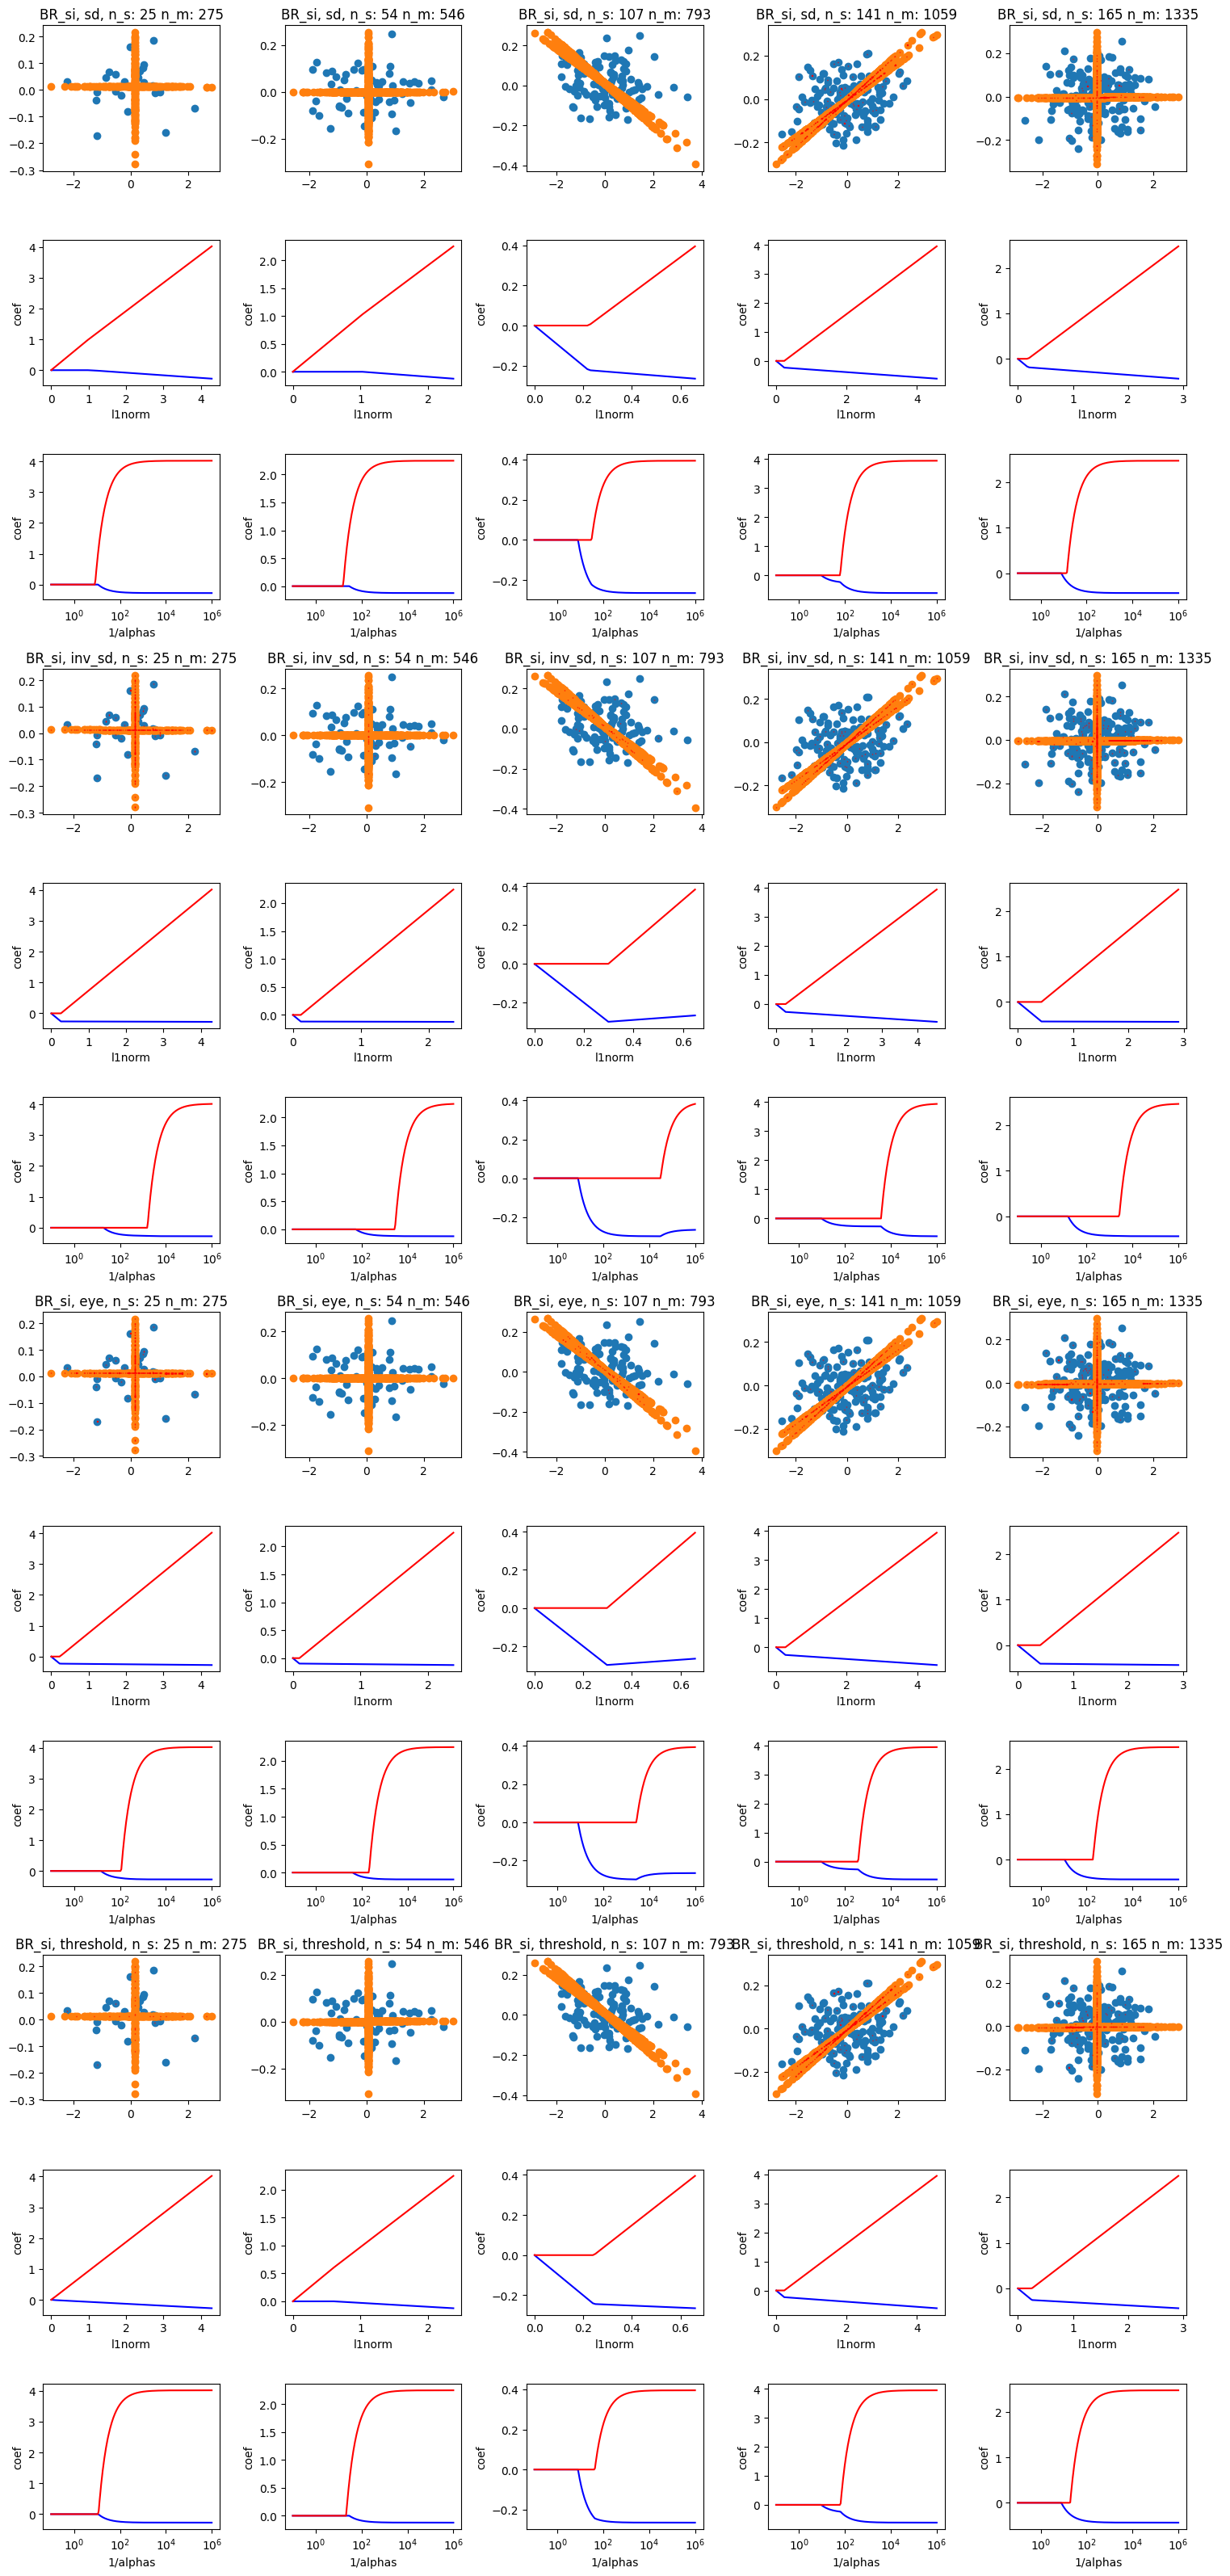

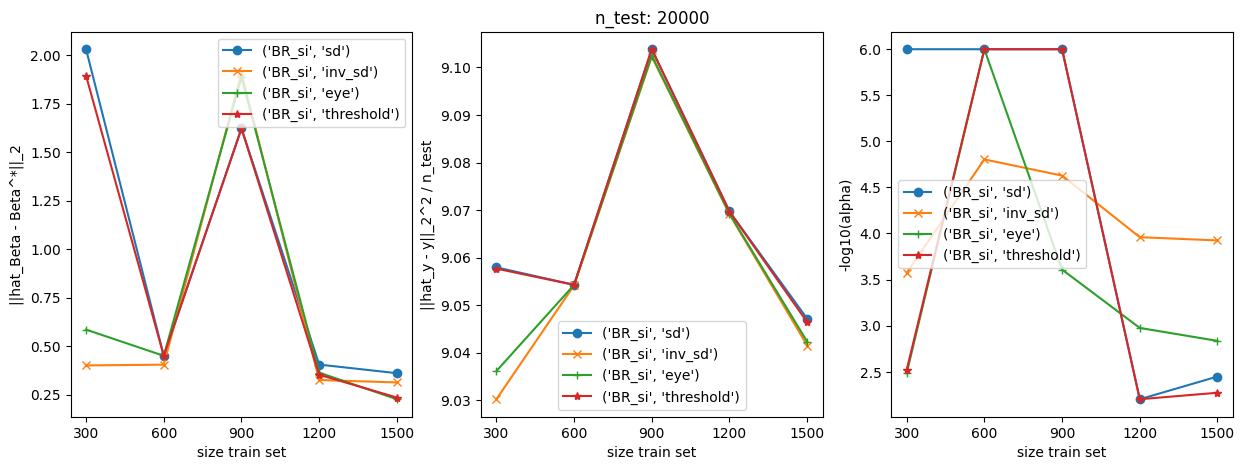

In [124]:
np.random.seed(456)

info_axis = 'train'  # train or p_seen
n_train = [300, 600, 900, 1200, 1500]
p_seen_both = [0.1, 0.1, 0.1, 0.1, 0.1]
error_vec =  [3, 3, 3, 3, 3]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    #data = {'data': 'moons'},# 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'eye'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
                        ]


#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)


In [ ]:
# observe the main difference between (eye, inv_sd) and (sd, threshold) in the dataset with 300 point at the level of coefficient
# for (sd, threshold) the survival time of the coefficient is the same, they die at the same moment, so it is more difficult to find a valut of 1/alpha that is good for both.
# for (eye, inv_sd) the survival time is different, in particular the small coefficient die later

change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}]
n_tot :  [21000, 21000, 21000, 21000, 21000]
n_train :  [1000, 1000, 1000, 1000, 1000]
n_test :  [20000, 20000, 20000, 20000, 20000]
dim :  [2, 2, 2, 2, 2]
beta_gt :  [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
perc_test :  [0.9523809523809523, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523]
err :  [{'type': 'Gaussian_on_y', 'scaling': 3}, {'type': 'Gaussian_on_y', 'scalin

100%|██████████| 200/200 [00:09<00:00, 21.52it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  116  best 1/best_alpha  83.09941949353387 , min score  9.027078086339642
best coeff  [-0.45583708  2.26207012]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  594  nbr_miss :  406
---....---....----....--> diag matrix:  [ 1.15058453 11.21066245]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 20.87it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  67  best 1/best_alpha  4397.603609302721 , min score  9.023733877102863
best coeff  [-0.48771469  1.82375267]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  594  nbr_miss :  406
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.01it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  96  best 1/best_alpha  419.870708444391 , min score  9.023899938060378
best coeff  [-0.48112586  1.87372237]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  594  nbr_miss :  406
---....---....----....--> diag matrix:  [0.86912345 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.06it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  116  best 1/best_alpha  83.09941949353387 , min score  9.026766719924474
best coeff  [-0.45586703  2.22356614]
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  413  nbr_miss :  587
---....---....----....--> diag matrix:  [0.85086693 0.08637908]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.69it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.000962401467833
best coeff  [-0.51473393  0.76984245]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  413  nbr_miss :  587
---....---....----....--> diag matrix:  [ 1.1752719  11.57687759]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 24.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.001050805608159
best coeff  [-0.51465412  0.76596516]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  413  nbr_miss :  587
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 22.78it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.000969389062034
best coeff  [-0.51472716  0.76953331]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  413  nbr_miss :  587
---....---....----....--> diag matrix:  [0.85086693 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  9.000962506169113
best coeff  [-0.51473384  0.76983786]
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  189  nbr_miss :  811
---....---....----....--> diag matrix:  [0.77721086 0.07671347]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.18it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  108  best 1/best_alpha  158.85651294280527 , min score  8.98787616023143
best coeff  [-0.49150487  1.97586421]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  189  nbr_miss :  811
---....---....----....--> diag matrix:  [ 1.28665213 13.03552075]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 20.91it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  49  best 1/best_alpha  18896.52339691212 , min score  8.987798661026988
best coeff  [-0.51049402  1.88979635]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  189  nbr_miss :  811
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.10it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  81  best 1/best_alpha  1414.9912974345757 , min score  8.98775839255657
best coeff  [-0.50801083  1.88334551]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  189  nbr_miss :  811
---....---....----....--> diag matrix:  [0.77721086 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.05it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  107  best 1/best_alpha  172.25859653987874 , min score  8.987796404130613
best coeff  [-0.49306252  1.93636951]
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  102  nbr_miss :  898
---....---....----....--> diag matrix:  [0.92110127 0.09559446]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.76it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  116  best 1/best_alpha  83.09941949353387 , min score  8.960634103670676
best coeff  [-0.39851634  2.95039237]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  102  nbr_miss :  898
---....---....----....--> diag matrix:  [ 1.08565696 10.46085676]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 23.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  67  best 1/best_alpha  4397.603609302721 , min score  8.954425547804389
best coeff  [-0.40226918  2.64638412]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  102  nbr_miss :  898
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 24.68it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  95  best 1/best_alpha  455.29350748669475 , min score  8.955396891821072
best coeff  [-0.39669638  2.64840062]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  102  nbr_miss :  898
---....---....----....--> diag matrix:  [0.92110127 0.1       ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:08<00:00, 22.78it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  116  best 1/best_alpha  83.09941949353387 , min score  8.960327651908496
best coeff  [-0.39177919  2.87781759]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1.  , 0.  ],
       [0.  , 0.01]])}
you are here
(21000, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  20  nbr_miss :  980
---....---....----....--> diag matrix:  [0.98743605 0.10126243]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 22.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  84  best 1/best_alpha  1109.752496412072 , min score  9.09157660891572
best coeff  [-0.32991776 -0.16518402]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  20  nbr_miss :  980
---....---....----....--> diag matrix:  [1.01272381 9.87533087]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 20.90it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  36  best 1/best_alpha  54158.713780794766 , min score  9.090784672931857
best coeff  [-0.33043236 -0.14943   ]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  20  nbr_miss :  980
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.37it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  63  best 1/best_alpha  6080.224261649421 , min score  9.090929046109745
best coeff  [-0.33154906 -0.16402469]


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  1000 nbr_seen (train):  20  nbr_miss :  980
---....---....----....--> diag matrix:  [0.98743605 0.10126243]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:09<00:00, 21.67it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  84  best 1/best_alpha  1109.752496412072 , min score  9.09157660891572
best coeff  [-0.32991776 -0.16518402]
x_axis---->  [0.6, 0.4, 0.2, 0.1, 0.02]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.45583708,  2.26207012]), array([-0.51473393,  0.76984245]), array([-0.49150487,  1.97586421]), array([-0.39851634,  2.95039237]), array([-0.32991776, -0.16518402])], 'l2_dist_best_coeff_gt': [np.float64(0.2657651440833659), np.float64(1.230245778537635), np.float64(0.02558717044564207), np.float64(0.9557952652627646), np.float64(2.1718540002834588)], 'best_score': [np.float64(9.027078086339642), np.float64(9.000962401467833), np.float64(8.98787616023143), np.float64(8.960634103670676), np.float64(9.09157660891572)], 'best_alpha': [np.float64(1.9195979899497484), np.float64(6.0), np.float64(2.201005025125628), np.float64(1.9195979899497484), np.float64(3.0452261306532664)]}, ('BR_si', 'inv_sd'): {'best_coeff': [array([-0.48771469

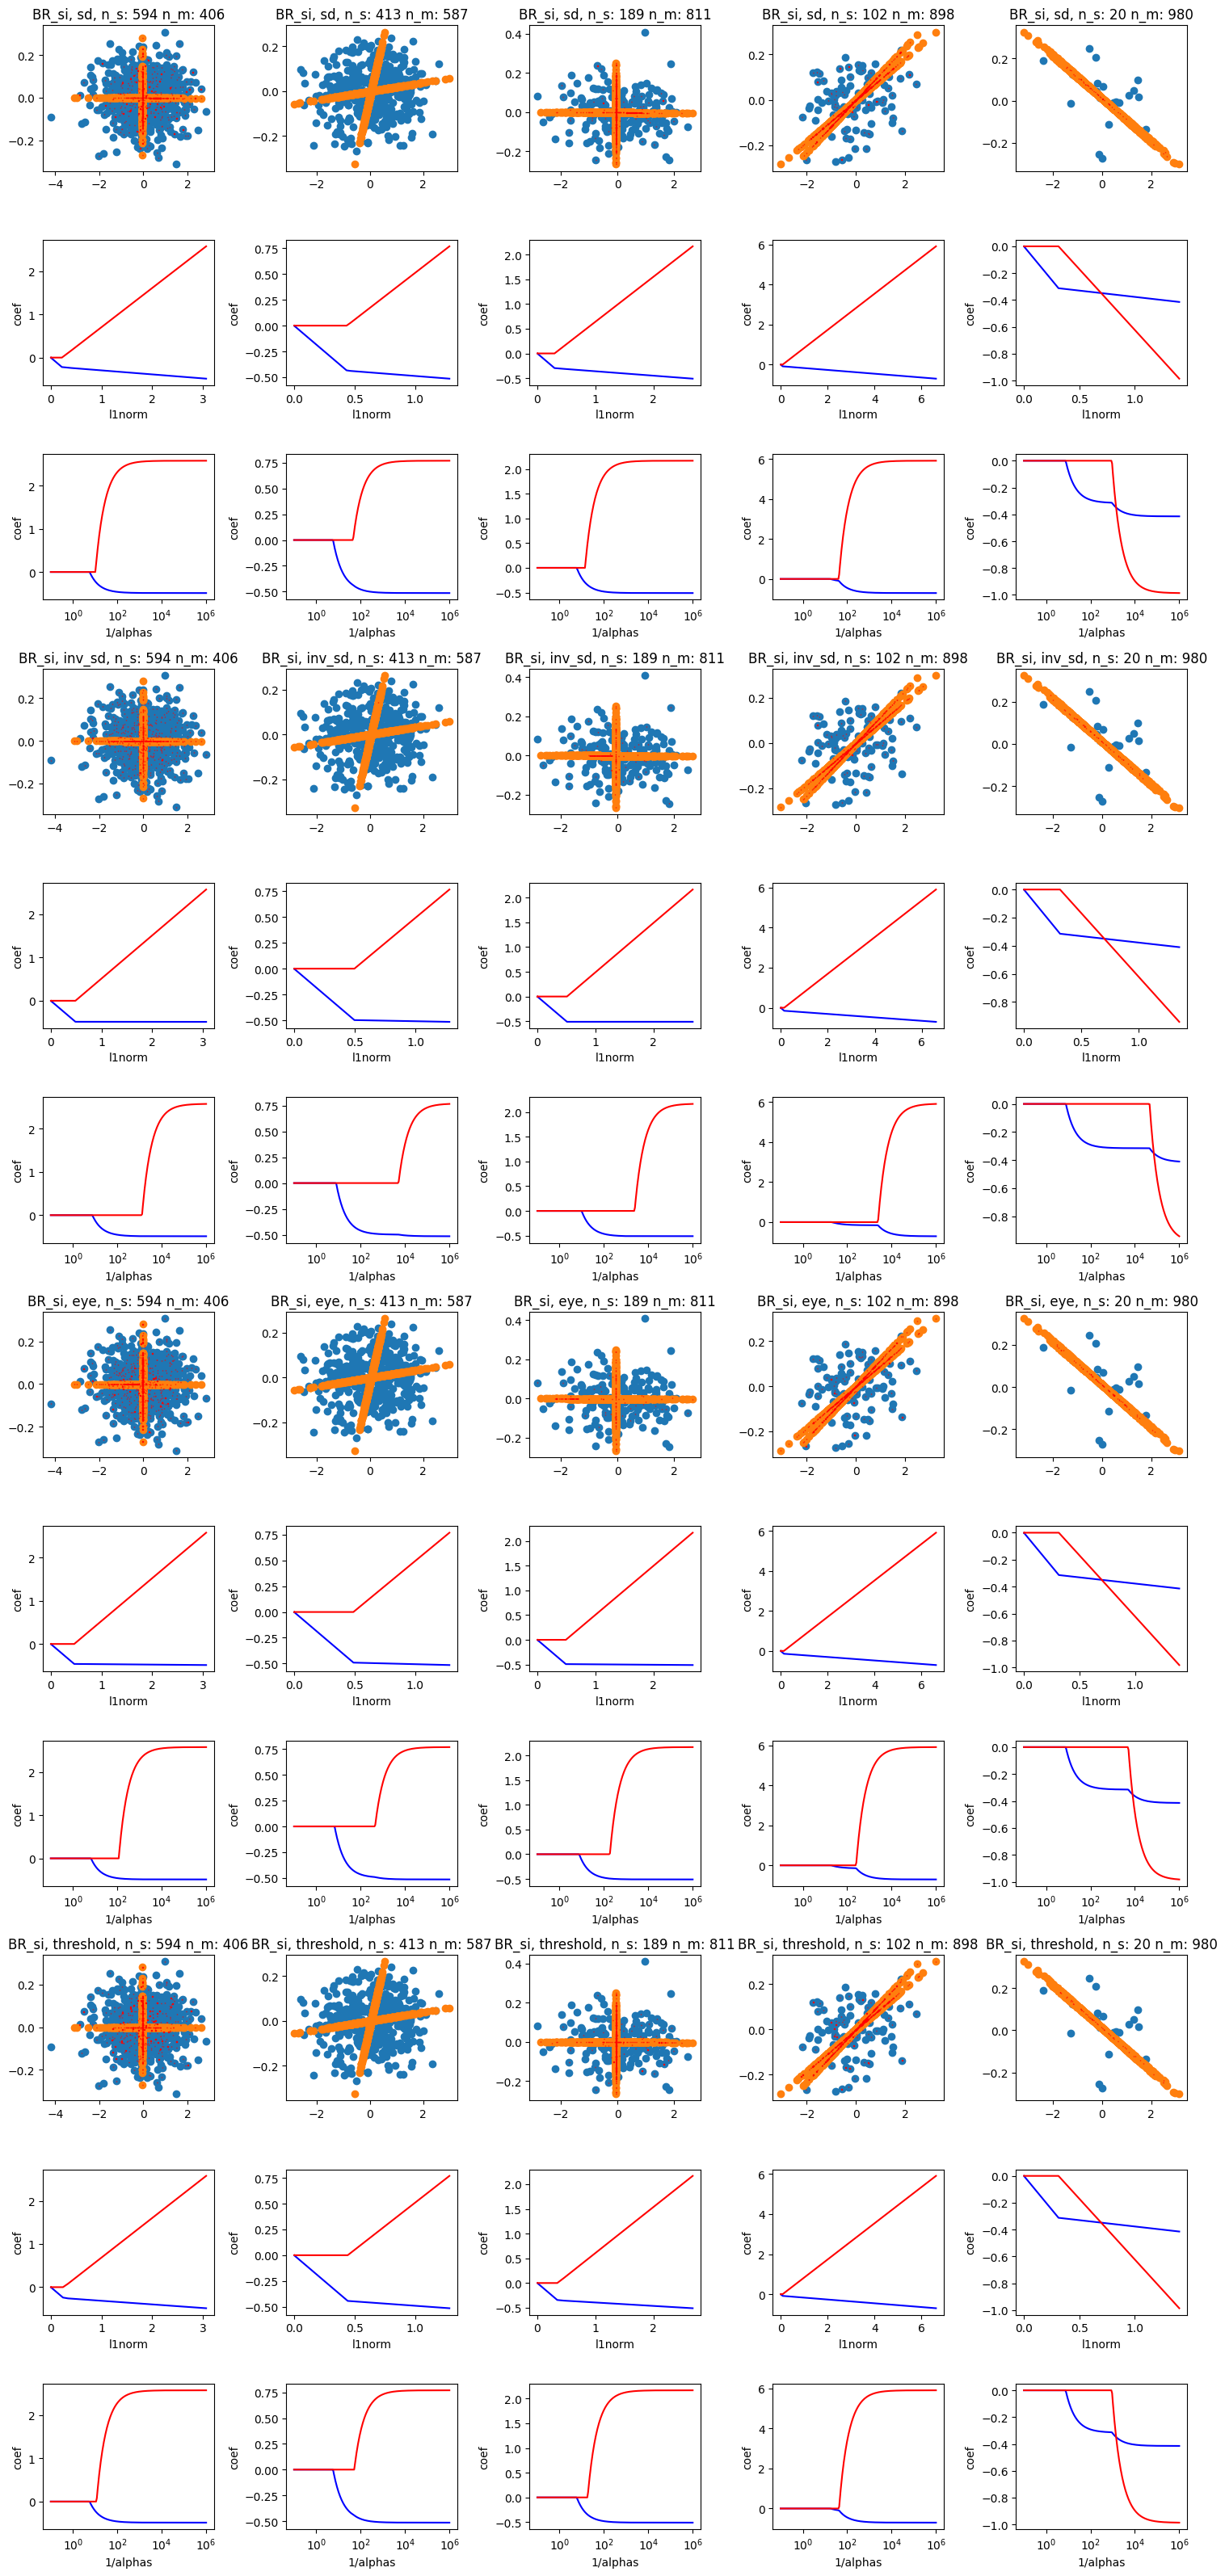

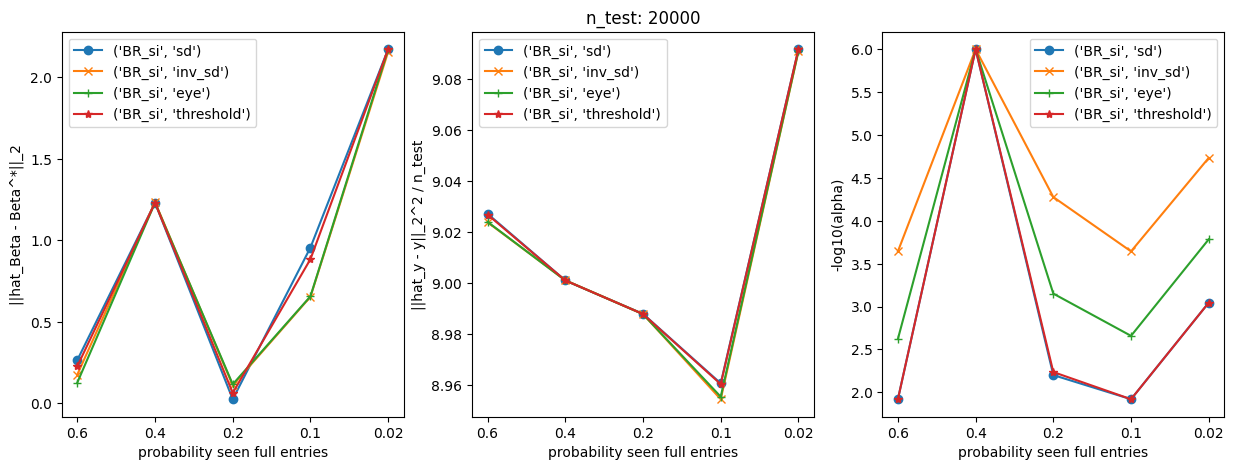

In [125]:
np.random.seed(456)

info_axis = 'p_seen'  # train or p_seen
n_train = [1000, 1000, 1000, 1000, 1000]
p_seen_both = [0.6, 0.4, 0.2, 0.1, 0.02]
error_vec =  [3, 3, 3, 3, 3]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    #data = {'data': 'moons'},# 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'eye'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
                        ]


#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)


In [126]:
np.random.seed(456)

info_axis = 'train'  # train or p_seen
n_train = [300, 600, 900, 1200, 1500]
p_seen_both = [0.1, 0.1, 0.1, 0.1, 0.1]
error_vec =  [5, 5, 5, 5, 5]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    #data = {'data': 'moons'},# 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    #data = {'data': 'circles', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    data = {'data': 'circles'},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'eye'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
                        ]


#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)


change nbr_experiments to match the size of n_train
data :  [{'data': 'circles'}, {'data': 'circles'}, {'data': 'circles'}, {'data': 'circles'}, {'data': 'circles'}]
n_tot :  [20300, 20600, 20900, 21200, 21500]
n_train :  [300, 600, 900, 1200, 1500]
n_test :  [20000, 20000, 20000, 20000, 20000]
dim :  [2, 2, 2, 2, 2]
beta_gt :  [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
perc_test :  [0.9852216748768473, 0.970873786407767, 0.9569377990430622, 0.9433962264150944, 0.9302325581395349]
err :  [{'type': 'Gaussian_on_y', 'scaling': 5}, {'type': 'Gaussian_on_y', 'scaling': 5}, {'type': 'Gaussian_on_y', 'scaling': 5}, {'type': 'Gaussian_on_y', 'scaling': 5}, {'type': 'Gaussian_on_y', 'scaling': 5}]
p_miss :  [[0.1, 0.45, 0.45], [0.1, 0.45, 0.45], [0.1, 0.45, 0.45], [0.1, 0.45, 0.45], [0.1, 0.45, 0.45]]
[{'imp_method': 'BR_si', 'cov_strategy': 'sd'}, {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}, {'imp_method': 'BR_si', 'cov_stra

100%|██████████| 200/200 [00:02<00:00, 79.56it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  0  best 1/best_alpha  1000000.0 , min score  25.743213739758104
best coeff  [0.66074308 0.6628478 ]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
-------> size test:  20000  , size train:  300 nbr_seen (train):  30  nbr_miss :  270
---....---....----....--> diag matrix:  [2.00881045 1.7874926 ]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 87.49it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  119  best 1/best_alpha  65.1733960488242 , min score  25.289648727812473
best coeff  [0.02174447 0.83182431]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
-------> size test:  20000  , size train:  300 nbr_seen (train):  30  nbr_miss :  270
---....---....----....--> diag matrix:  [1. 1.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 84.77it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
best idx  132  best 1/best_alpha  22.739657523579275 , min score  25.472337843206844
best coeff  [0.02979788 0.6132308 ]
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
-------> size test:  20000  , size train:  300 nbr_seen (train):  30  nbr_miss :  270
---....---....----....--> diag matrix:  [0.49780705 0.55944288]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


 26%|██▌       | 51/200 [00:00<00:02, 56.77it/s]


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x781323b8fd80> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x781323b8d8a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
np.random.seed(456)

info_axis = 'train'  # train or p_seen
n_train = [300, 600, 900, 1200, 1500]
p_seen_both = [0.1, 0.1, 0.1, 0.1, 0.1]
error_vec =  [5, 5, 5, 5, 5]
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.5], [-0.5, 0.01]])},
    #data = {'data': 'circles', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    #data = {'data': 'circles'},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)

for key, value in dicc.items():
  print(key,": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'eye'},
                        {'imp_method': 'BR_si', 'cov_strategy': 'threshold', 'threshold': 0.1}
                        ]


#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)


In [ ]:
# this experiment highlight how the shape of the uncertainty is important for smaller dataset

In [ ]:
#dicc = {'data':
#        'n_tot':
#        'n_train':
#        'n_test':
#        'dim':
#        'beta_gt':
#        'perc_test':
#        'p_miss':
#        'err':
np.random.seed(98765)
main_variable = 'size_train'
n_train = [100, 500, 1000, 1500, 2000]
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
if main_variable == 'perc_miss':
  info_x_axis = {'name': 'seen percentage', 'vector': p_seen}
elif main_variable == 'size_train':
  info_x_axis = {'name': 'size train set', 'vector': n_train}


dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = 'moons',
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.1, 0.45, 0.45],
    err_dic = {'type': 'Gaussian', 'scaling': 3}
)
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]

print("Dictionary with all the data")
for key, value in dicc.items():
  print(key,": " , value)


dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}
list_methods_strategy = [dicc_imp1, dicc_imp2]

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
#dicc = {'data':
#        'n_tot':
#        'n_train':
#        'n_test':
#        'dim':
#        'beta_gt':
#        'perc_test':
#        'p_miss':
#        'err':
np.random.seed(9876543)
main_variable = 'size_train'
n_train = [100, 500, 1000, 1500, 2000]
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
if main_variable == 'perc_miss':
  info_x_axis = {'name': 'seen percentage', 'vector': p_seen}
elif main_variable == 'size_train':
  info_x_axis = {'name': 'size train set', 'vector': n_train}


dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = 'moons',
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.1, 0.45, 0.45],
    err_dic = {'type': 'Gaussian', 'scaling': 10}
)
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]

print("Dictionary with all the data")
for key, value in dicc.items():
  print(key,": " , value)


dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}
list_methods_strategy = [dicc_imp1, dicc_imp2]

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
#dicc = {'data':
#        'n_tot':
#        'n_train':
#        'n_test':
#        'dim':
#        'beta_gt':
#        'perc_test':
#        'p_miss':
#        'err':
np.random.seed(9876543)
main_variable = 'size_train'
n_train = [100, 500, 1000, 1500, 2000]
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
if main_variable == 'perc_miss':
  info_x_axis = {'name': 'seen percentage', 'vector': p_seen}
elif main_variable == 'size_train':
  info_x_axis = {'name': 'size train set', 'vector': n_train}


dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = 'circles',
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.2, 0.4, 0.4],
    err_dic = {'type': 'Gaussian', 'scaling': 5}
)
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]

print("Dictionary with all the data")
for key, value in dicc.items():
  print(key,": " , value)


dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
#dicc = {'data':
#        'n_tot':
#        'n_train':
#        'n_test':
#        'dim':
#        'beta_gt':
#        'perc_test':
#        'p_miss':
#        'err':
np.random.seed(987654321)
main_variable = 'perc_miss'
n_train = 1500
p_seen = [0.8, 0.5, 0.2, 0.1, 0.02]
if main_variable == 'perc_miss':
  info_x_axis = {'name': 'seen percentage', 'vector': p_seen}
elif main_variable == 'size_train':
  info_x_axis = {'name': 'size train set', 'vector': n_train}
else:
  print("ERROR: WRONG NAME")

dicc = make_dictionary_data(
    nbr_experiments= len(p_seen), n_train = n_train, n_test=20000,
    data = 'circles',
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.2, 0.4, 0.4],
    err_dic = {'type': 'Gaussian', 'scaling': 5}
)
dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.2, 0.4, 0.4], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]

print("Dictionary with all the data")
for key, value in dicc.items():
  print(key,": " , value)


dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
#dicc = {'data':
#        'n_tot':
#        'n_train':
#        'n_test':
#        'dim':
#        'beta_gt':
#        'perc_test':
#        'p_miss':
#        'err':
np.random.seed(987654321)
main_variable = 'perc_miss'
n_train = 1500
p_seen = [0.8, 0.5, 0.2, 0.1, 0.02]
if main_variable == 'perc_miss':
  info_x_axis = {'name': 'seen percentage', 'vector': p_seen}
elif main_variable == 'size_train':
  info_x_axis = {'name': 'size train set', 'vector': n_train}
else:
  print("ERROR: WRONG NAME")

dicc = make_dictionary_data(
    nbr_experiments= len(p_seen), n_train = n_train, n_test=10000,
    data = 'circles',
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.2, 0.4, 0.4],
    err_dic = {'type': 'Gaussian', 'scaling': 10}
)
dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.2, 0.4, 0.4], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]

print("Dictionary with all the data")
for key, value in dicc.items():
  print(key,": " , value)


dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(47)
n_train = [250, 500, 1000, 1500, 2000]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.1, 0.45, 0.45],
    err_dic = {'type': 'Gaussian', 'scaling': 5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(47)
n_train = [250, 500, 1000, 1500]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[10, 0], [0, 0.001]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.1, 0.45, 0.45],
    err_dic = {'type': 'Gaussian', 'scaling': 2.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(4743)
n_train = [650, 1300, 2000]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.5]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.1, 0.45, 0.45],
    err_dic = {'type': 'Gaussian', 'scaling': 2.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(4743)
n_train = [650, 1300, 2000]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[5, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.1, 0.45, 0.45],
    err_dic = {'type': 'Gaussian', 'scaling': 2.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
np.random.seed(4567)
n_train = [500, 750, 1000]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.1, 0.45, 0.45],
    err_dic = {'type': 'Gaussian', 'scaling': 2.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(4567)
n_train = [500, 750, 1000]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[5, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.5, 0.25, 0.25],
    err_dic = {'type': 'Gaussian', 'scaling': 2.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(4567)
n_train = [500, 750, 1500]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[10, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.5, 0.25, 0.25],
    err_dic = {'type': 'Gaussian', 'scaling': 7.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(4567)
n_train = [500, 750, 1500]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[10, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.2, 0.4, 0.4],
    err_dic = {'type': 'Gaussian', 'scaling': 2.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(4567)
n_train = [500, 750, 1500]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[10, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.3, 0.35, 0.35],
    err_dic = {'type': 'Gaussian_on_X', 'scaling': 5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
np.random.seed(456)
n_train = [600, 850, 1600, 2200]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0], [0, 0.01]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.06, 0.47, 0.47],
    err_dic = {'type': 'Gaussian_on_X', 'scaling': 7.5}
)
info_x_axis = {'name': 'size train set', 'vector': n_train}
#dicc['n_train'] = n_train
#p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
#dicc['p_miss'] = [[0.8, 0.1, 0.1], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
#info_x_axis = {'name': 'perc seen', 'vector': p_seen}
#info_x_axis = {'name': 'seen percentage', 'vector': p_seen}

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'BR_si', 'cov_strategy': 'inv_sd'}
dicc_imp3 = {'imp_method': 'BR_si', 'cov_strategy': 'eye'}
#dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
#dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab, [ax_1, ax_2])

## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
plt.legend()  # Show legend
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)
